In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import Ridge,ElasticNetCV,ElasticNet
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import *

# Data Preprocessing

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    fxn()

## Explore Raw Data

In [3]:
features_df  = pd.read_csv("Data/features.csv")
train_df = pd.read_csv("Data/train.csv")
stores_df = pd.read_csv("Data/stores.csv")
test_df = pd.read_csv("Data/test.csv")

### Explore Features DF

This file contains additional data related to the store, department, and regional activity for the given dates.

In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [5]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
# Imputing CPI and Unemployement values with mean of respective store
features_df['CPI'] = features_df['CPI'].fillna(features_df.groupby('Store')['CPI'].transform('mean'))
features_df['Unemployment'] = features_df['Unemployment'].fillna(features_df.groupby('Store')['Unemployment'].transform('mean'))

### Explore Train/Test DF

This is the historical training data, which covers to 2010-02-05 to 2012-11-01.
`test_df` file is identical to train.csv, except we have withheld the weekly sales.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [8]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [10]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


Since the test dataset is missing the actual weekly sales for those dates (the y label) becuase this was originally used for a Kaggle competition, let's derive both the dev and test datasets from the train_df for the purposes of our project for now (we may decide to use this test dataset and submit to the Kaggle compeititon later on.

### Explore Stores_DF

This file contains anonymized information about the 45 stores, indicating the type and size of store.

In [11]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [12]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Merge the Features/Train Datasets together for one DS

In [13]:
features_df = features_df.merge(stores_df, how='inner', on='Store')
df = pd.merge(left=features_df,right=train_df,on=["Store","Date"],how='left')

In [14]:
df.drop("IsHoliday_x",inplace=True,axis=1)
df.rename(columns={"IsHoliday_y":"IsHoliday"},inplace=True)

In [15]:
df.rename(columns={"Type":"Store_Type"},inplace=True)
df.rename(columns={"Size":"Store_Size"},inplace=True)

In [16]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,1.0,24924.50,False
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2.0,50605.27,False
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,3.0,13740.12,False
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,4.0,39954.04,False
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5.0,32229.38,False


In [17]:
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
# Adding week number for imputing
# Reference: https://www.includehelp.com/python/converting-a-pandas-date-to-week-number.aspx
df['Week'] = df['Date'].dt.isocalendar().week

## Missing Value Treatment and Clean Up

In [19]:
# Check is there any missing values across each column
df.isna().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       270892
MarkDown2       310793
MarkDown3       284667
MarkDown4       286859
MarkDown5       270138
CPI                  0
Unemployment         0
Store_Type           0
Store_Size           0
Dept              1755
Weekly_Sales      1755
IsHoliday         1755
Week                 0
dtype: int64

In [20]:
stores_df.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [21]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (features_df.isnull().sum()/features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total missing values', 'Percentage'])
missing_data

,Total missing values,Percentage
MarkDown2,310793.0,0.643346
MarkDown4,286859.0,0.577045
MarkDown3,284667.0,0.558852
MarkDown1,270892.0,0.507692
MarkDown5,270138.0,0.505495
IsHoliday,1755.0,0.000000
Weekly_Sales,1755.0,NaN
Dept,1755.0,NaN
Store_Type,0.0,NaN
Store_Size,0.0,NaN


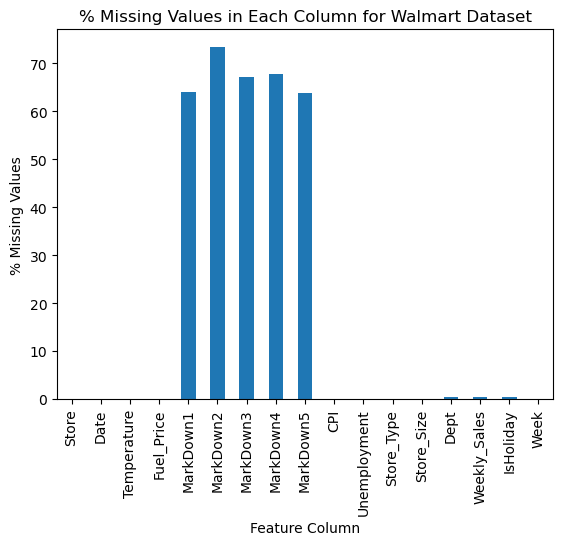

In [22]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

Some of the info needed for the target y label and relevant department is missing, let's see how many rows are missing and drop them if it's possible

In [23]:
df[df['Dept'].isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday,Week
10244,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,A,151315,NaN,NaN,NaN,44
10245,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573000,A,151315,NaN,NaN,NaN,45
10246,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573000,A,151315,NaN,NaN,NaN,46
10247,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573000,A,151315,NaN,NaN,NaN,47
10248,1,2012-11-30,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573000,A,151315,NaN,NaN,NaN,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423320,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,187.298763,8.640467,B,118221,NaN,NaN,NaN,26
423321,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,187.298763,8.640467,B,118221,NaN,NaN,NaN,27
423322,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,187.298763,8.640467,B,118221,NaN,NaN,NaN,28
423323,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,187.298763,8.640467,B,118221,NaN,NaN,NaN,29


Only a very small subset of the dataset contains NaNs in the Dept column (and it seems that the NaNs in thr Weekly Sales Column are on the , so let's just drop those rows.

In [24]:
df = df[df['Dept'].notna()]

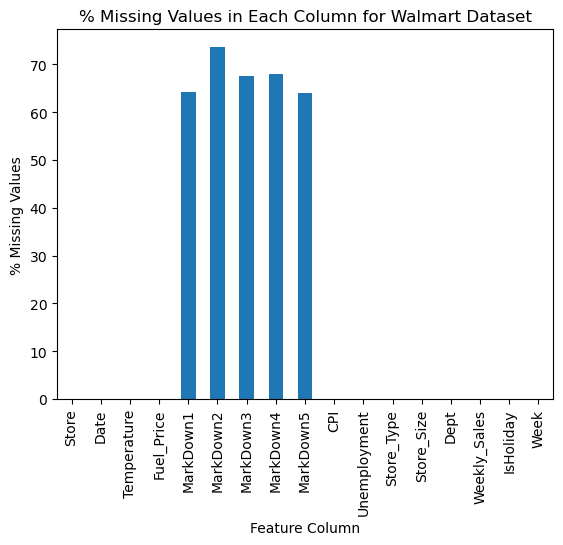

In [25]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

### MarkDown Column Clean-Up

From competition: MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NaN.

In [26]:
df[df['MarkDown1'].notna()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday,Week
6587,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,1.0,18689.54,False,45
6588,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,2.0,44936.47,False,45
6589,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,3.0,9959.64,False,45
6590,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,4.0,36826.52,False,45
6591,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,5.0,31002.65,False,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423281,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,93.0,2487.80,False,43
423282,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,94.0,5203.31,False,43
423283,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,95.0,56017.47,False,43
423284,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,97.0,6817.48,False,43


A lot of data from 1 year is missing markdowns, and there are NaNs, so for these NaNs we may want to consider a mean simple imputer based on the department and store type.

### Imputing Markdown Data


<b>First Step</b>: Replacing missing markdown data with the average across similar departments during the same year week.<br>
<b>Second Step</b>: Replace the remaining missing values with the average value across each markdown type (this is to account for week 44 where no markdown values were registered)

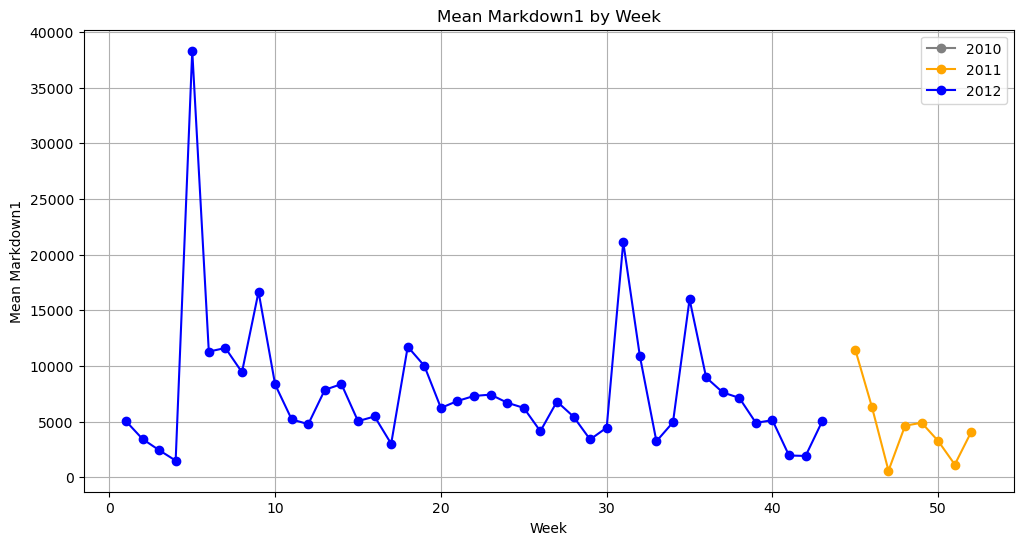

In [27]:
# Show missing values around week 44
markdown_mean_2010 = df[pd.to_datetime(df['Date']).dt.year == 2010].groupby('Week')['MarkDown1'].mean()
markdown_mean_2011 = df[pd.to_datetime(df['Date']).dt.year == 2011].groupby('Week')['MarkDown1'].mean()
markdown_mean_2012 = df[pd.to_datetime(df['Date']).dt.year == 2012].groupby('Week')['MarkDown1'].mean()

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(markdown_mean_2010.index, markdown_mean_2010.values, label = '2010', color = 'grey', marker='o', linestyle='-')
plt.plot(markdown_mean_2011.index, markdown_mean_2011.values, label = '2011', color = 'orange', marker='o', linestyle='-')
plt.plot(markdown_mean_2012.index, markdown_mean_2012.values, label = '2012', color = 'blue', marker='o', linestyle='-')

plt.title('Mean Markdown1 by Week')
plt.xlabel('Week')
plt.ylabel('Mean Markdown1')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#reference from: 
# https://stackoverflow.com/questions/73411674/scikit-learn-imputer-in-a-pandas-dataframe-group-by-id

# Replace MarkDown NaN with mean amount of same dept and store type
df['MarkDown1'] = df.groupby(["Dept",  "Week"]).MarkDown1.transform(lambda x: x.fillna(x.mean()))
df['MarkDown2'] = df.groupby(["Dept",  "Week"]).MarkDown2.transform(lambda x: x.fillna(x.mean()))
df['MarkDown3'] = df.groupby(["Dept",  "Week"]).MarkDown3.transform(lambda x: x.fillna(x.mean()))
df['MarkDown4'] = df.groupby(["Dept",  "Week"]).MarkDown4.transform(lambda x: x.fillna(x.mean()))
df['MarkDown5'] = df.groupby(["Dept",  "Week"]).MarkDown5.transform(lambda x: x.fillna(x.mean()))

In [29]:
df.isna().sum()

Store               0
Date                0
Temperature         0
Fuel_Price          0
MarkDown1        6288
MarkDown2       33307
MarkDown3        6985
MarkDown4        6288
MarkDown5        6288
CPI                 0
Unemployment        0
Store_Type          0
Store_Size          0
Dept                0
Weekly_Sales        0
IsHoliday           0
Week                0
dtype: int64

In [30]:
# Second step of imputation. Replacing missing values with the mean across markdown types.
df['MarkDown1'].fillna(df['MarkDown1'].mean(), inplace= True)
df['MarkDown2'].fillna(df['MarkDown2'].mean(), inplace= True)
df['MarkDown3'].fillna(df['MarkDown3'].mean(), inplace= True)
df['MarkDown4'].fillna(df['MarkDown4'].mean(), inplace= True)
df['MarkDown5'].fillna(df['MarkDown5'].mean(), inplace= True)

In [31]:
df.isna().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Store_Type      0
Store_Size      0
Dept            0
Weekly_Sales    0
IsHoliday       0
Week            0
dtype: int64

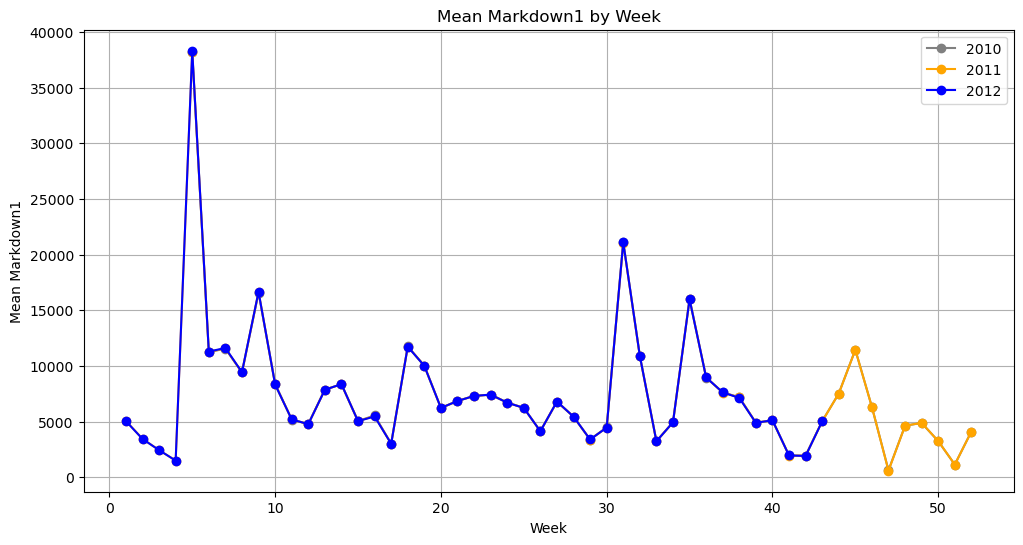

In [32]:
# Showing mean markdown1 after imputation
markdown_mean_2010 = df[pd.to_datetime(df['Date']).dt.year == 2010].groupby('Week')['MarkDown1'].mean()
markdown_mean_2011 = df[pd.to_datetime(df['Date']).dt.year == 2011].groupby('Week')['MarkDown1'].mean()
markdown_mean_2012 = df[pd.to_datetime(df['Date']).dt.year == 2012].groupby('Week')['MarkDown1'].mean()

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(markdown_mean_2010.index, markdown_mean_2010.values, label = '2010', color = 'grey', marker='o', linestyle='-')
plt.plot(markdown_mean_2011.index, markdown_mean_2011.values, label = '2011', color = 'orange', marker='o', linestyle='-')
plt.plot(markdown_mean_2012.index, markdown_mean_2012.values, label = '2012', color = 'blue', marker='o', linestyle='-')

plt.title('Mean Markdown1 by Week')
plt.xlabel('Week')
plt.ylabel('Mean Markdown1')
plt.legend()
plt.grid(True)
plt.show()

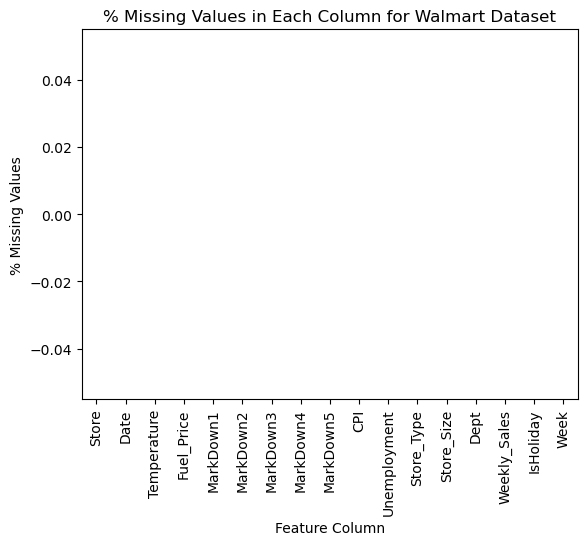

In [33]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

It appears that there is a very small % of missing values in the MarkDown columns even after imputation. This is likely because there is no existing data available for the store type and dept that can be used to impute these nulls. For these very small number cases, we will just use the simple imputation of MarkDown by Dept (although the Store Type may impact the MarkDown amount in these columns, since the # of columns that this impacts is very small, we expect the impact to also be very small.

No more missing values!

In [34]:
# save a copy for some feature importance later
no_na_df = df.copy()

### Categorical Variables/Data Clean-Up

Before handling the other missing values (i.e. MarkDown columns, let's do some clean-up.

In [35]:
from sklearn.impute import SimpleImputer

df["IsHoliday"] = pd.get_dummies(df["IsHoliday"], 
                drop_first = True, 
                dtype = int )


In [36]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday,Week
0,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,1.0,24924.50,0,5
1,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,2.0,50605.27,0,5
2,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,3.0,13740.12,0,5
3,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,4.0,39954.04,0,5
4,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,5.0,32229.38,0,5


In [37]:
df["Store_Type"].nunique()

3

We do not know if store type has any ordinal importance, so we will just use a simple imputer for this/

In [38]:
type_dummies = pd.get_dummies(df["Store_Type"], 
                drop_first = True, 
                dtype = int )

df = df.drop(["Store_Type"], axis = 1)

df = pd.concat([df, type_dummies], axis=1)
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Week,B,C
0,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,1.0,24924.50,0,5,0,0
1,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,2.0,50605.27,0,5,0,0
2,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,3.0,13740.12,0,5,0,0
3,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,4.0,39954.04,0,5,0,0
4,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,5.0,32229.38,0,5,0,0


In [39]:
df.rename(columns={"B":"Store_Type_B"},inplace=True)
df.rename(columns={"C":"Store_Type_C"},inplace=True)
df.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Week,Store_Type_B,Store_Type_C
423281,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,93.0,2487.80,0,43,1,0
423282,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,94.0,5203.31,0,43,1,0
423283,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,95.0,56017.47,0,43,1,0
423284,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,97.0,6817.48,0,43,1,0
423285,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,98.0,1076.80,0,43,1,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 423285
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  Store_Size    421570 non-null  int64         
 12  Dept          421570 non-null  float64       
 13  Weekly_Sales  421570 non-null  float64       
 14  IsHoliday     421570 non-null  int32         
 15  Week          421570 n

### Splitting the Data

In [41]:
# sort by date for time series forecasting
df = df.sort_values(by = 'Date')

# we delete negative weekly sales as they only represent 0.3% of the data.
# we are unsure about the significance of negative sales. (negative sales is different negative profit)
df = df[df['Weekly_Sales'] > 0]

# split data into features and labels
df_X = df.drop(columns=['Weekly_Sales'])
df_y = df['Weekly_Sales']

## Exploratory Data Analysis

### Macro Analyses

Before looking into each department's trends for patterns, let's look at the overall dataset patterns

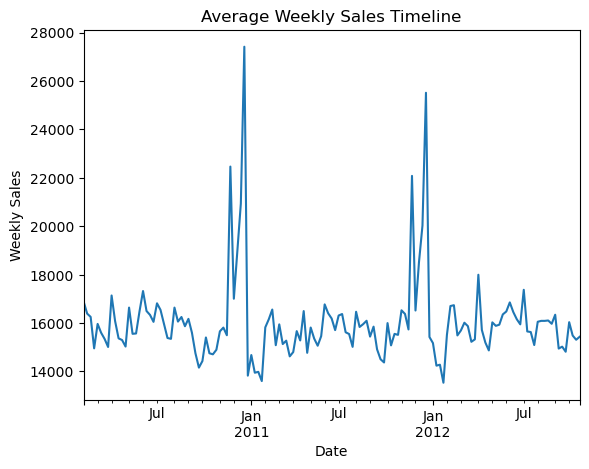

In [42]:
sales_df = df.groupby("Date")["Weekly_Sales"].mean().transpose().plot(
                                                                                                                  kind = "line",
                                                                     title = "Average Weekly Sales Timeline",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Date")

Let's zoom in to 1 year of sales, like Jan 2011 - Jan 2012.

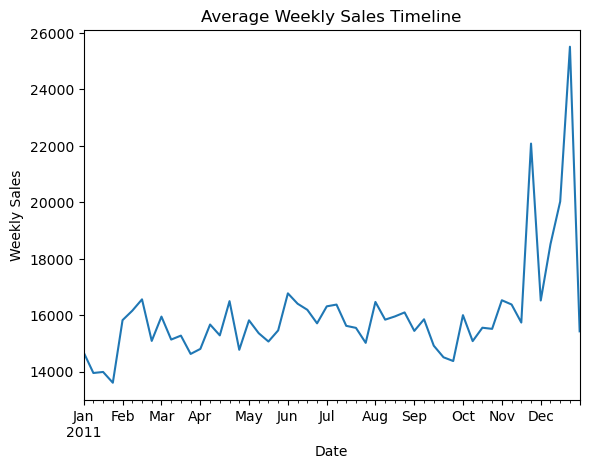

In [43]:
sales_df = df[(df["Date"] > "2011-01-01") & (df["Date"] <= "2012-01-01")].groupby("Date")["Weekly_Sales"].mean().transpose().plot(
                                                                                                                  kind = "line",
                                                                     title = "Average Weekly Sales Timeline",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Date")

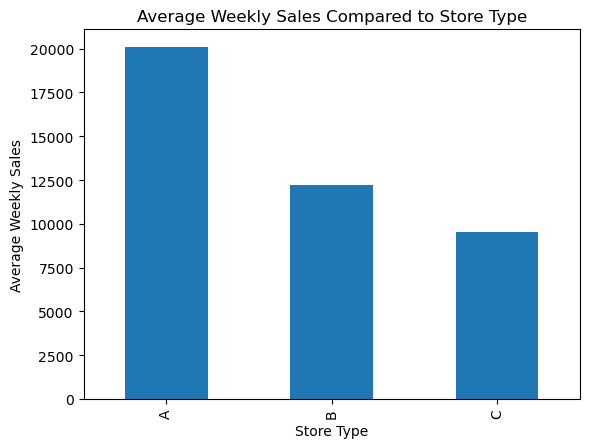

In [44]:
sales_df = no_na_df.groupby("Store_Type")["Weekly_Sales"].mean().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Compared to Store Type",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store Type")

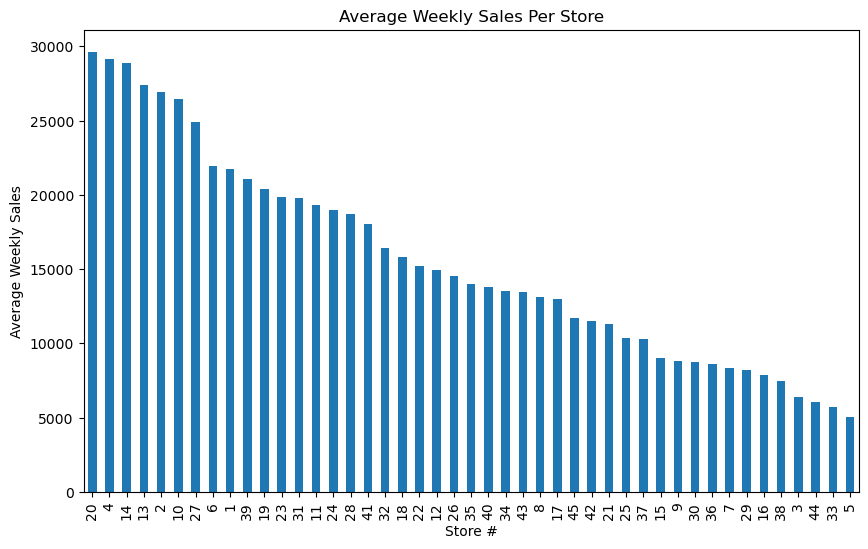

In [45]:
plt.figure(figsize=(10,6))
sales_df = df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")


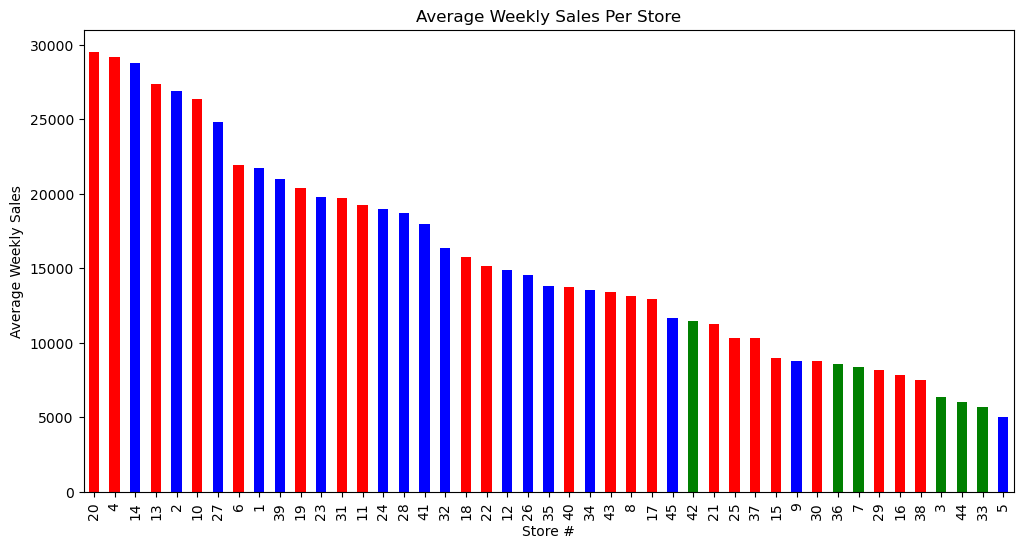

In [46]:
plt.figure(figsize=(12,6))
colors = {'A': 'r', 'B': 'b', 'C': 'g'}
sales_df = no_na_df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                    color=[colors[i] for i in no_na_df.groupby("Store")['Store_Type'].max()],
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")

Color legend isn't showing up, but we see that type is not impactful to store sales except store type C sales tend to have lower weekly sales than store types A and B.

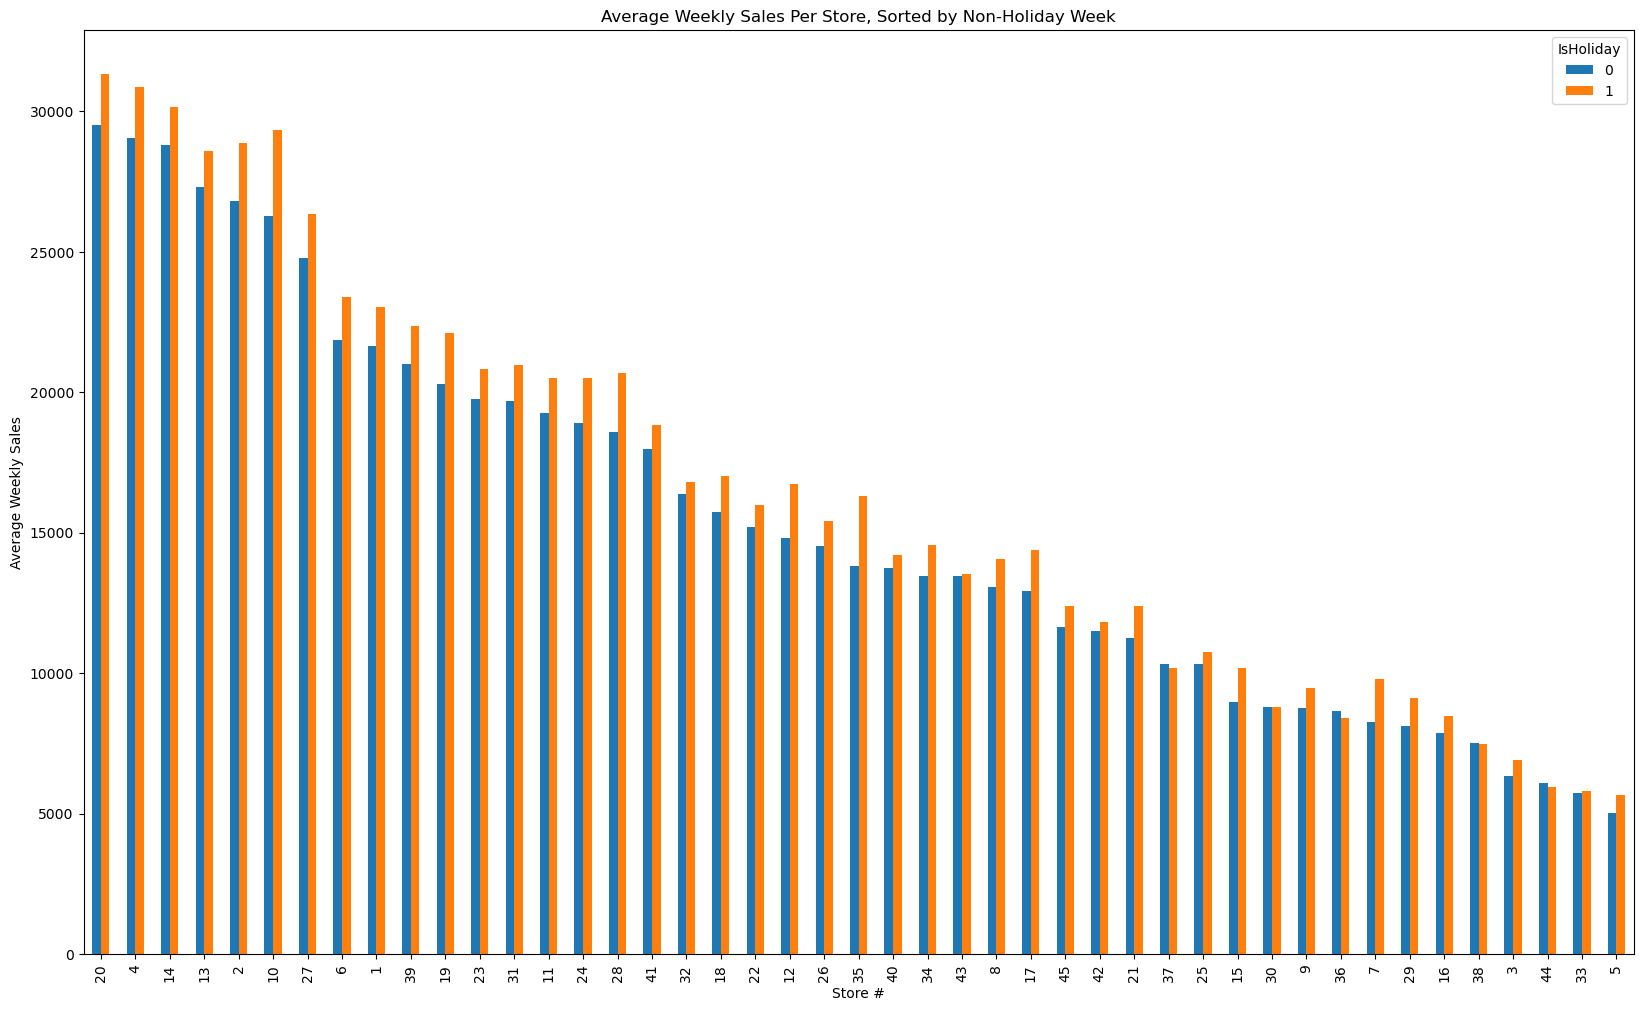

In [47]:
sales_df = df.groupby(["Store", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =0,ascending=False).plot(figsize=(20,12),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Store, Sorted by Non-Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")

This chart is in similar trend to the overall dept weekly sales chart, so we will ignore this.

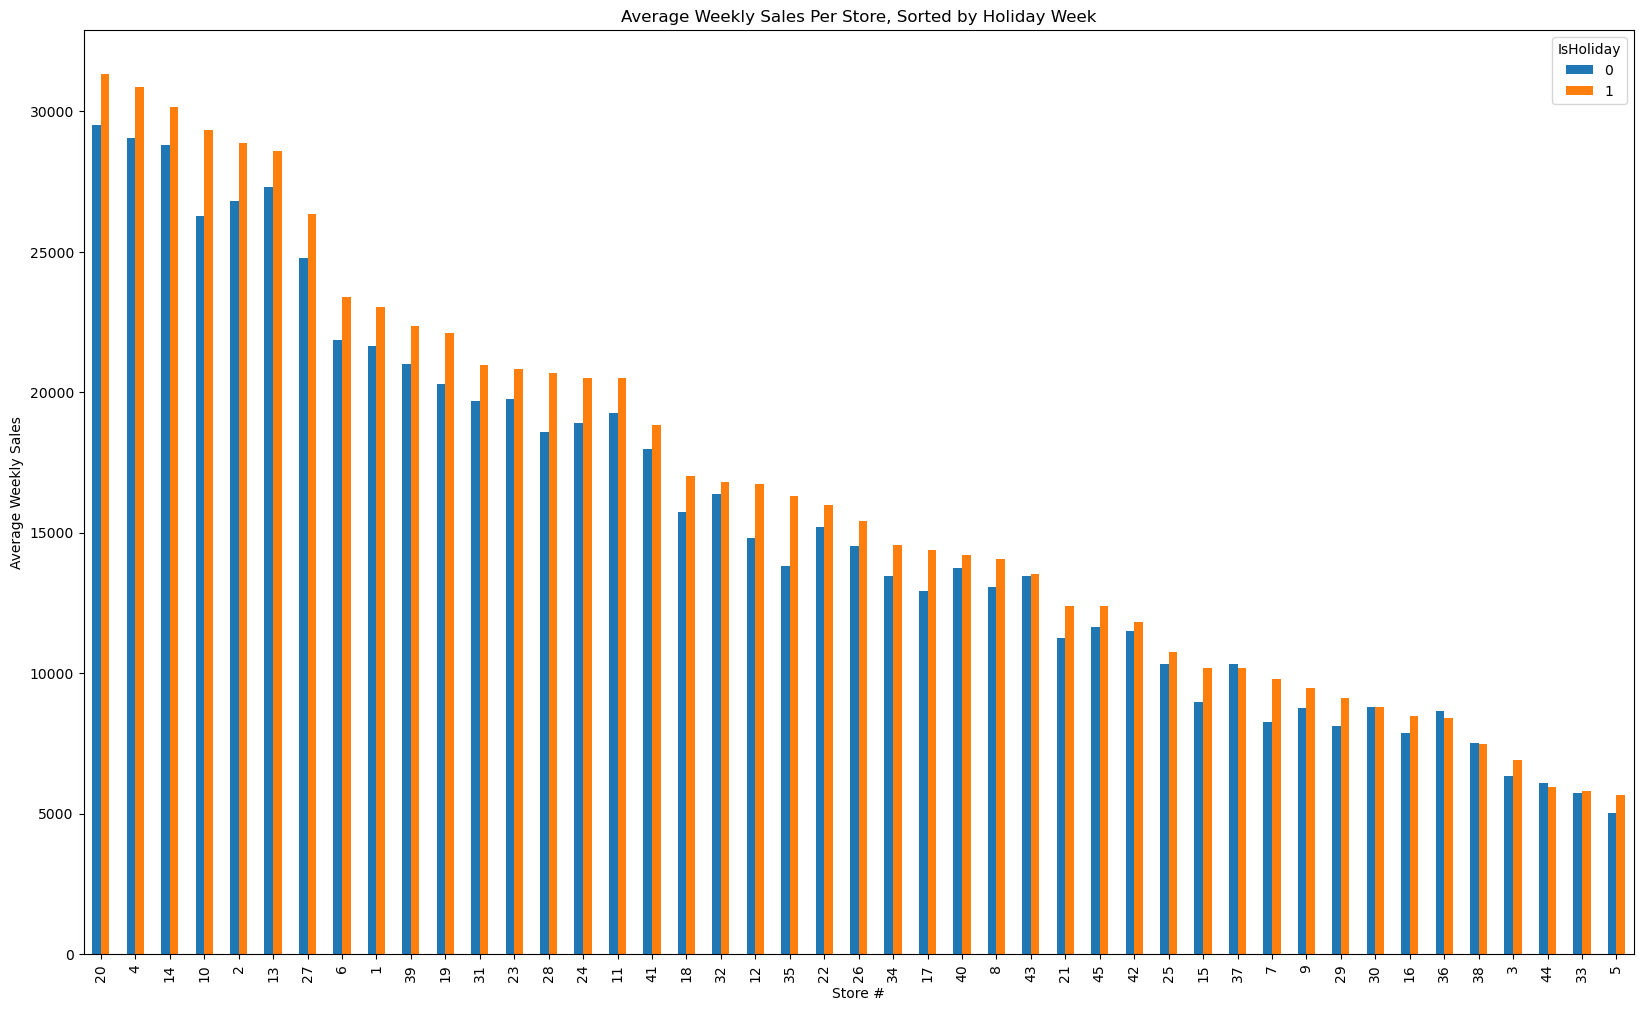

In [48]:
sales_df = df.groupby(["Store", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =1,ascending=False).plot(figsize=(20,12),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Store, Sorted by Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")




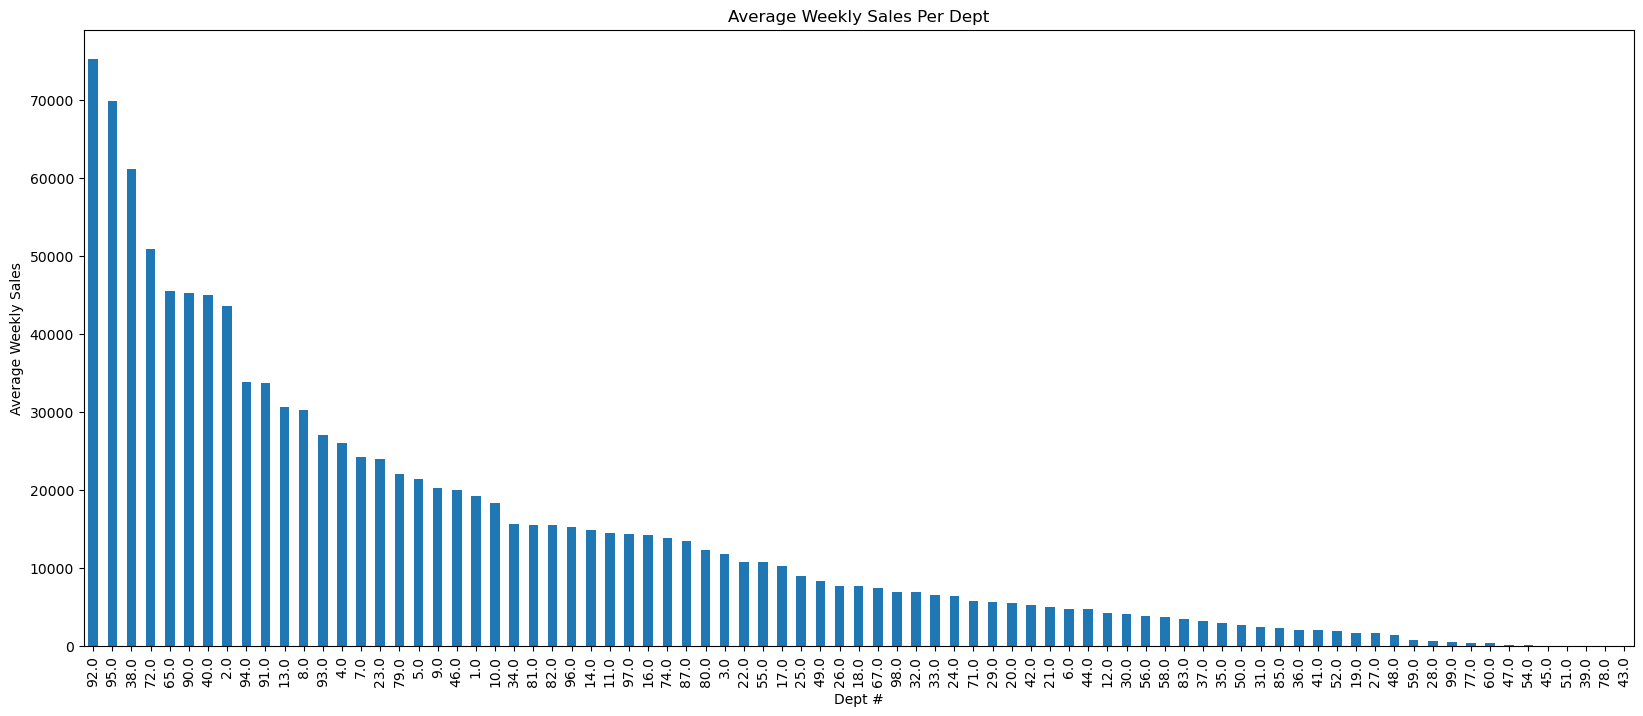

In [49]:
sales_df = df.groupby("Dept")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     figsize = (20,8),
                                                                            title = "Average Weekly Sales Per Dept",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")

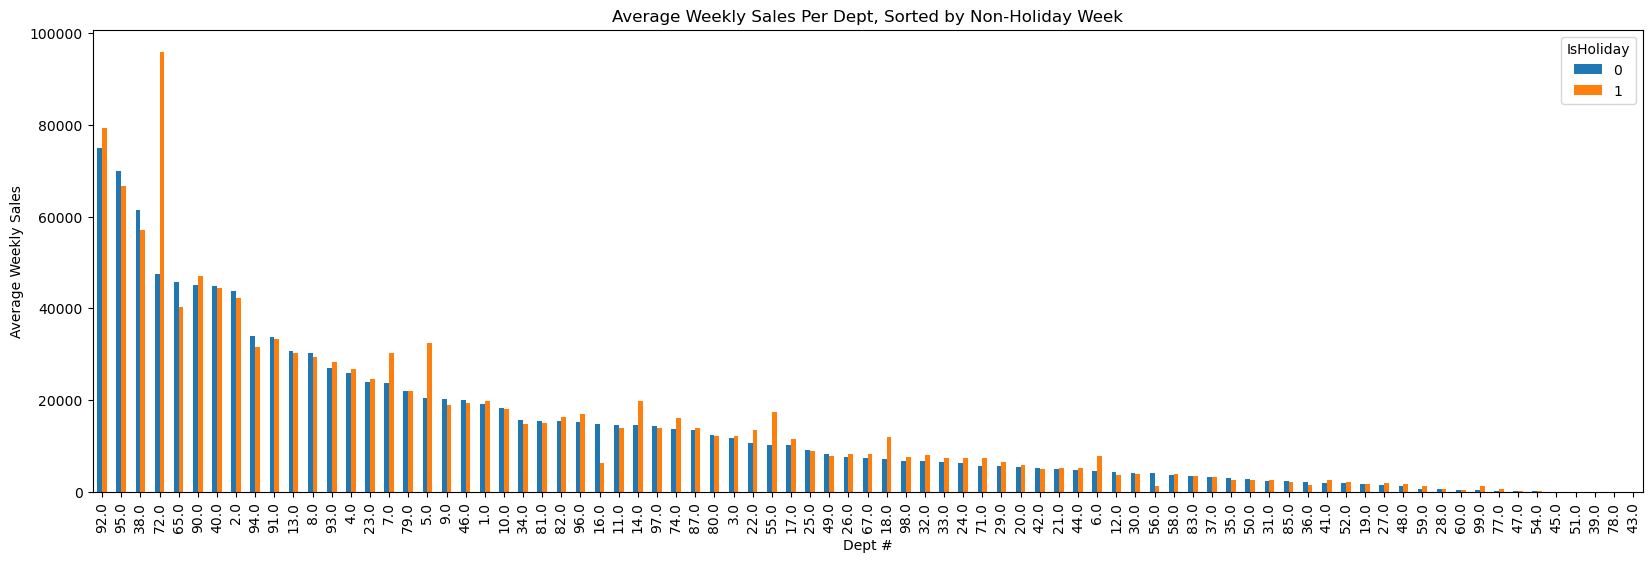

In [50]:
sales_df = df.groupby(["Dept", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =0,ascending=False).plot(figsize=(20,6),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Dept, Sorted by Non-Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")

This chart is in similar trend to the overall dept weekly sales chart, so we will ignore this.

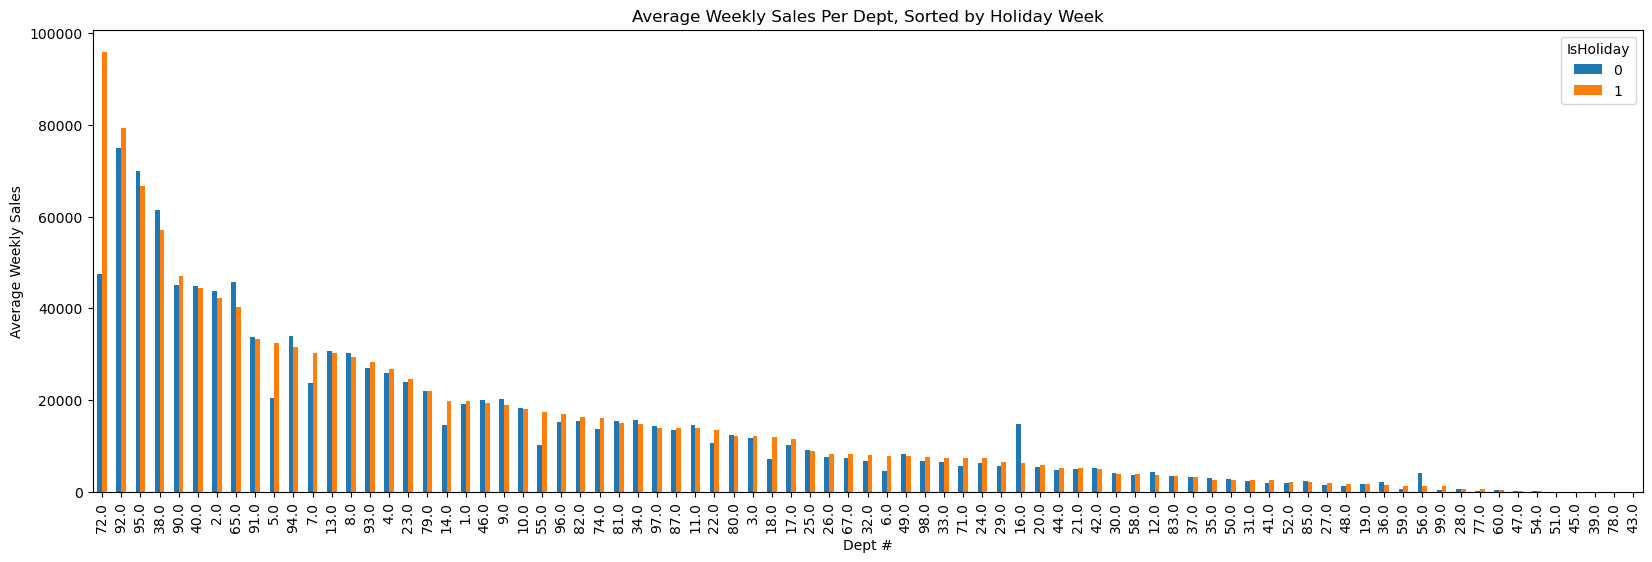

In [51]:
sales_df = df.groupby(["Dept", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =1,ascending=False).plot(figsize=(20,6),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Dept, Sorted by Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")




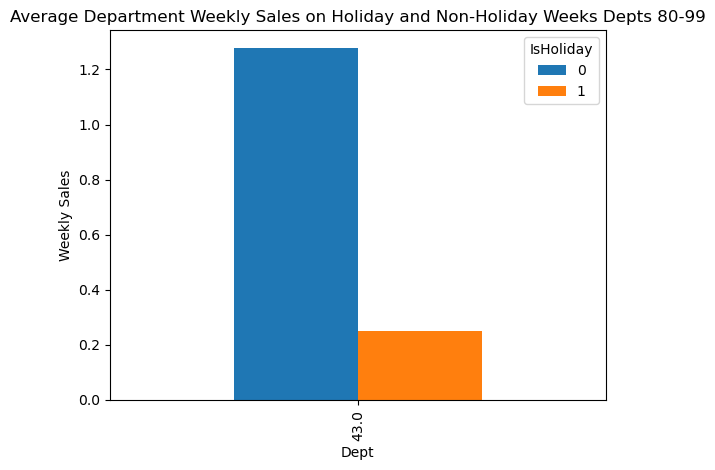

In [52]:
# sanity check to make sure there are sales, even in the worst performing dept
holiday_df6 = df[df["Dept"] == 43.0].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(
                                                                                                                  kind = "bar",
                                                                     title = "Average Department Weekly Sales on Holiday and Non-Holiday Weeks Depts 80-99",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

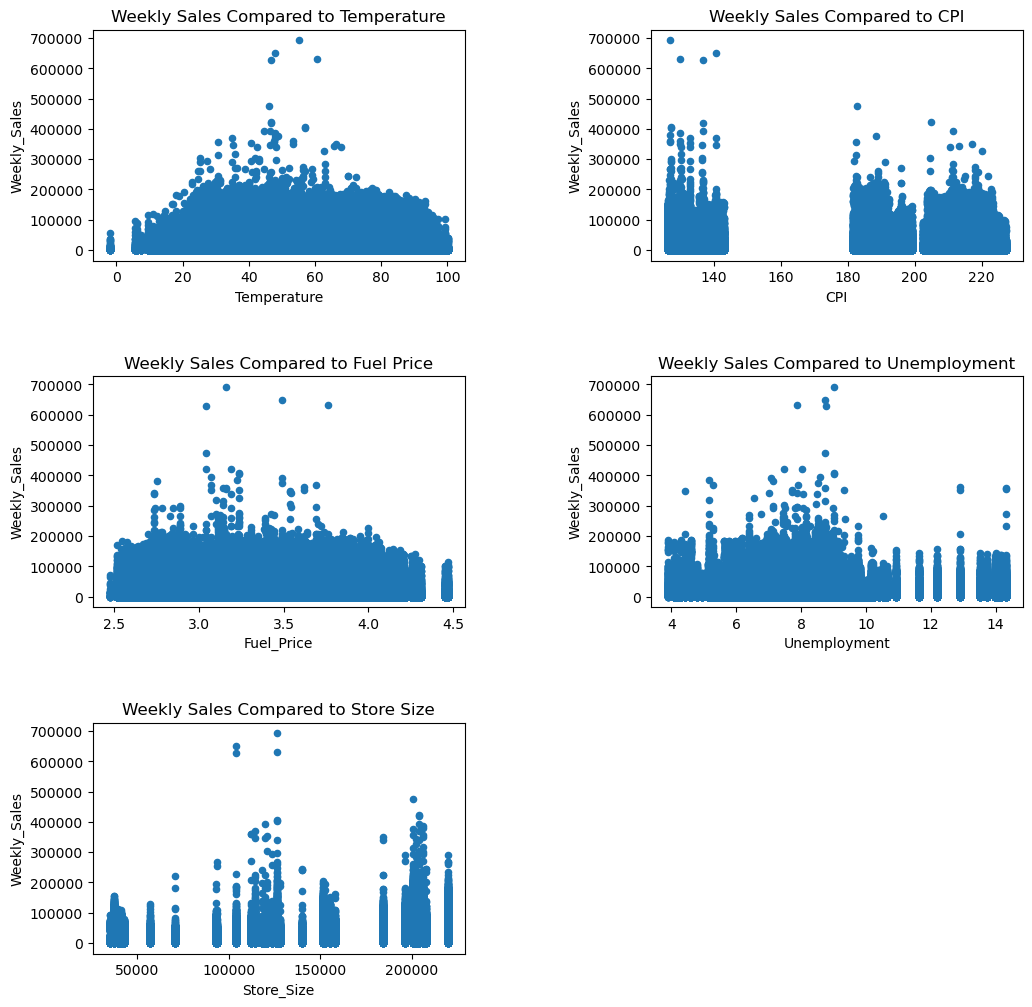

In [53]:
fig, axs = plt.subplots(3,2)
 
fig.set_size_inches(12, 12) # from https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.set_size_inches

#figure, axis = plt.subplots(2, 2)
temp_df = df.plot(ax = axs[0,0],
                    kind = "scatter",
                    x = "Temperature",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Temperature")

cpi_df = df.plot(ax = axs[0,1],
                    kind = "scatter",
                    x = "CPI",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to CPI")

fuel_df = df.plot(ax = axs[1,0],
                    kind = "scatter",
                    x = "Fuel_Price",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Fuel Price")

unemp_df = df.plot(ax = axs[1,1],
                    kind = "scatter",
                    x = "Unemployment",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Unemployment")

store_size_df = df.plot(ax = axs[2,0],
                    kind = "scatter",
                    x = "Store_Size",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Store Size")
fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

We see some features such as temperature, CPI, and unemployment do not really have an impact on weekly sales, so we should consider dropping those variables.

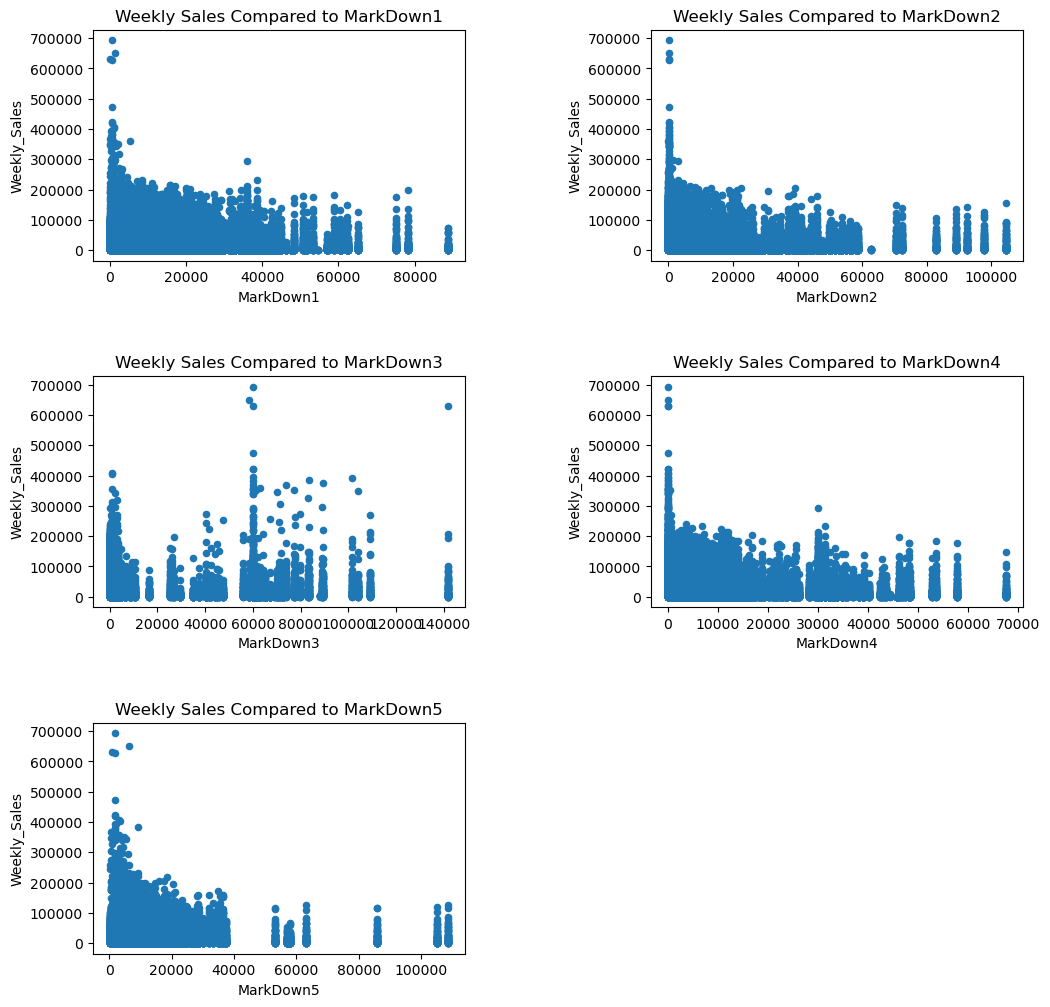

In [54]:
fig, axs = plt.subplots(3,2)
 
fig.set_size_inches(12, 12) # from https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.set_size_inches

#figure, axis = plt.subplots(2, 2)
md1_df = df.plot(ax = axs[0,0],
                    kind = "scatter",
                    x = "MarkDown1",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown1")

md2_df = df.plot(ax = axs[0,1],
                    kind = "scatter",
                    x = "MarkDown2",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown2")

md3_df = df.plot(ax = axs[1,0],
                    kind = "scatter",
                    x = "MarkDown3",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown3")

md4_df = df.plot(ax = axs[1,1],
                    kind = "scatter",
                    x = "MarkDown4",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown4")

md5_df = df.plot(ax = axs[2,0],
                    kind = "scatter",
                    x = "MarkDown5",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown5")
fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

<Axes: >

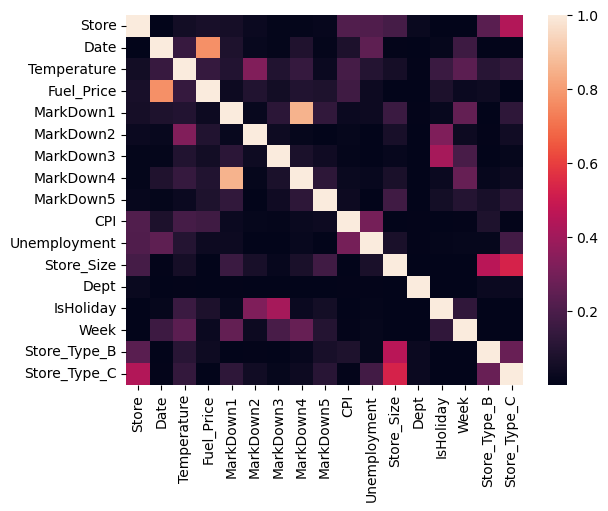

In [55]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(df_X.corr().abs())

In [56]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
print(df_X.corr().abs())

                 Store      Date  Temperature  Fuel_Price  MarkDown1  \
Store         1.000000  0.003159     0.050230    0.065321   0.056538   
Date          0.003159  1.000000     0.146955    0.771944   0.078760   
Temperature   0.050230  0.146955     1.000000    0.143700   0.091959   
Fuel_Price    0.065321  0.771944     0.143700    1.000000   0.034685   
MarkDown1     0.056538  0.078760     0.091959    0.034685   1.000000   
MarkDown2     0.028037  0.020666     0.324372    0.088504   0.021393   
MarkDown3     0.010066  0.008324     0.086519    0.047385   0.114836   
MarkDown4     0.011173  0.082721     0.143065    0.089298   0.855337   
MarkDown5     0.018188  0.007968     0.028204    0.080144   0.131823   
CPI           0.211261  0.077033     0.182223    0.164199   0.028550   
Unemployment  0.208759  0.243463     0.096768    0.033915   0.031458   
Store_Size    0.182763  0.005122     0.058413    0.003632   0.155062   
Dept          0.024258  0.003993     0.004727    0.003544   0.00

There are high correlations between Date/Fuel Price and MarkDown 1 & Markdown We will leave date/fuel price
since that correlation shouldn't impact the model, but we may consider dropping MarkDown 1 
or Markdown 4 or adding in some feature importance metrics.

In [57]:
# drop some uncorrelated variables to weekly sales
df_X = df_X.drop(columns=['CPI', "Unemployment", "Temperature"])

<Axes: >

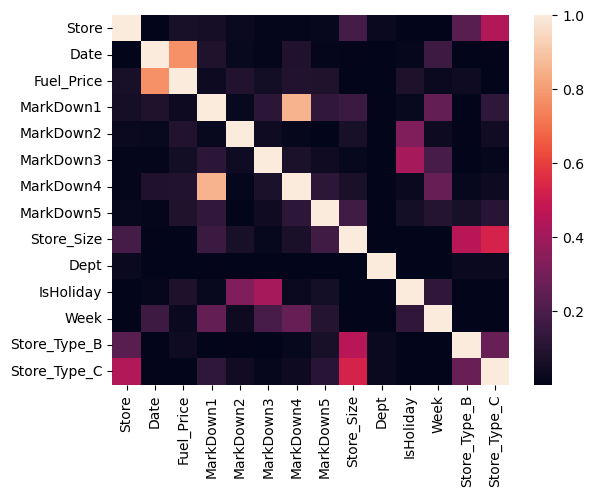

In [58]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(df_X.corr().abs())

### Micro Analyses

####  Old Dept Analysis



In [59]:
# did this earlier but it's covered in a previous chart

In [60]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Week,Store_Type_B,Store_Type_C
0,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,211.096358,8.106,151315,1.0,24924.50,0,5,0,0
332087,35,2010-02-05,27.19,2.784,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,135.352461,9.262,103681,3.0,14612.19,0,5,1,0
332088,35,2010-02-05,27.19,2.784,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,135.352461,9.262,103681,4.0,26323.15,0,5,1,0
332089,35,2010-02-05,27.19,2.784,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,135.352461,9.262,103681,5.0,36414.63,0,5,1,0
332090,35,2010-02-05,27.19,2.784,40430.008000,3161.955000,156.4365,32154.346000,6520.385750,135.352461,9.262,103681,6.0,11437.81,0,5,1,0


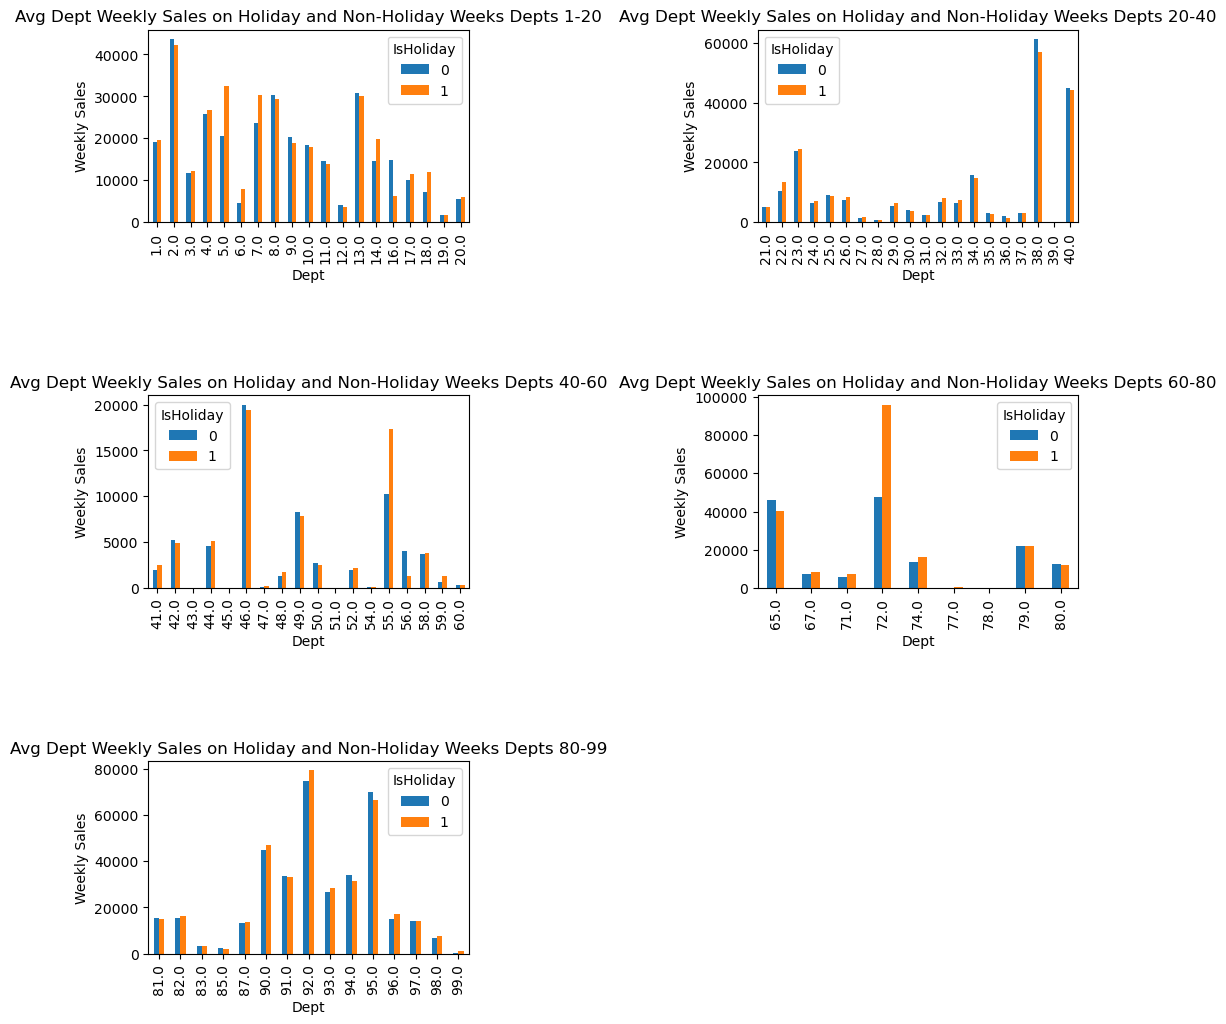

In [61]:
fig, axs = plt.subplots(3,2)

fig.set_size_inches(12, 12) 

holiday_df = df[df["Dept"] <= 20].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[0,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 1-20",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")
                                                                                       
holiday_df2 = df[(df["Dept"] > 20) & (df["Dept"] <= 40)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[0,1],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 20-40",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")
holiday_df3 = df[(df["Dept"] > 40) & (df["Dept"] <= 60)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[1,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 40-60",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

holiday_df4 = df[(df["Dept"] > 60) & (df["Dept"] <= 80)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[1,1],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 60-80",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

holiday_df5 = df[df["Dept"] > 80].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[2,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 80-99",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.9,
                    hspace=0.9)
plt.show()

## Train Test Split

Now let's explore some features in our test data.

In [62]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


Now let's do a time-series friendly split before feeding our data into our initial set of models. Note that we are not using the `test.csv` provided since it does not come with the true `Weekly_Sales` values, so we are deriving our test dataset from the provided train dataset for the focus of this project

### Additional Data Prep

In [63]:
df_X = df_X.drop(columns=["Date"])

##### Split data

In [64]:
#shuffle will be false because we want this to be time series
X_dev, X_test, y_dev, y_test = train_test_split(df_X, df_y, shuffle = False, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, shuffle = False, test_size=0.2, random_state = 42)

##### Standard Scaler

In [65]:
selected_features = ["Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Store_Size"]
scaler = StandardScaler()
dev_scaler = StandardScaler()

X_train[selected_features] = scaler.fit_transform(X_train[selected_features])
X_val[selected_features] = scaler.transform(X_val[selected_features])
X_test[selected_features] = scaler.transform(X_test[selected_features])

#using separate scaler to prevent data leakage
X_dev[selected_features] = dev_scaler.fit_transform(X_dev[selected_features])

## Initial Model Set-Up Predictions

### Ridge Regression

#### Default Model

In [145]:
base_model = Ridge(random_state = 42)

base_model.fit(X_dev, y_dev)
y_test_pred = base_model.predict(X_test)

test_mse_error_rrd = mean_squared_error(y_test, y_test_pred)
r2_score_rrd = r2_score(y_test, y_test_pred)
mae_rrd = mean_absolute_error(y_test, y_test_pred)

print(f"Default Ridge Regression Test Mean Squared Error with Negative Predictions: {test_mse_error_rrd:.2f}")
print(f"Default Ridge Regression Test R2 Score with Negative Predictions: {r2_score_rrd:.2f}")
print(f"Default Ridge Regression Test Mean Absolute Error with Negative Predictions: {mae_rrd:.2f}")

y_test_pred_corrected = np.maximum(y_test_pred, 0) # can't have negative sales

test_mse_error_rrd_c = mean_squared_error(y_test, y_test_pred_corrected)
r2_score_rrd_c = r2_score(y_test, y_test_pred_corrected )
mae_rrd_c = mean_absolute_error(y_test, y_test_pred_corrected)
print("***")
print(f"Default Ridge Regression Test Mean Squared Error with Correction: {test_mse_error_rrd_c:.2f}")
print(f"Default Ridge Regression Test R2 Score with Correction: {r2_score_rrd_c:.2f}")
print(f"Default Ridge Regression Test Mean Absolute Error with Correction: {mae_rrd_c:.2f}")
#print(f"Default Random Forest Regressor Test Mean Absolute Percentage Error: {mape_defaultrf:.2f}")

Default Ridge Regression Test Mean Squared Error with Negative Predictions: 442706774.88
Default Ridge Regression Test R2 Score with Negative Predictions: 0.08
Default Ridge Regression Test Mean Absolute Error with Negative Predictions: 14746.54
***
Default Ridge Regression Test Mean Squared Error with Correction: 442692521.85
Default Ridge Regression Test R2 Score with Correction: 0.08
Default Ridge Regression Test Mean Absolute Error with Correction: 14746.31


#### Hyperparameter-Tuned Ridge Regression

In [146]:
alphas = np.logspace(-4, 4, 100)

best_alpha = None
best_val_error = float('inf')
best_model = None

for alpha in alphas:
    current_model = Ridge(alpha=alpha, random_state = 42)
    current_model.fit(X_train, y_train)
    
    y_val_pred = current_model.predict(X_val)
    
    val_error = mean_squared_error(y_val, y_val_pred)

    if val_error < best_val_error:
        best_val_error = val_error
        best_alpha = alpha
        #best_model = current_model

#now use whole development DS to train
best_model = Ridge(alpha=best_alpha, random_state = 42)
best_model.fit(X_dev, y_dev)
y_test_pred = best_model.predict(X_test)


#test_error = mean_squared_error(y_test, y_test_pred)

# Report the results
print(f"Best Alpha for Ridge Regression: {best_alpha:.4f}")


test_mse_error_rr = mean_squared_error(y_test, y_test_pred)
r2_score_rr = r2_score(y_test, y_test_pred)
mae_rr = mean_absolute_error(y_test, y_test_pred)

print(f"Hyperparameter-Tuned Ridge Regression Test Mean Squared Error with Negative Predictions: {test_mse_error_rr:.2f}")
print(f"Hyperparameter-Tuned Ridge Regression Test R2 Score with Negative Predictions: {r2_score_rr:.2f}")
print(f"Hyperparameter-Tuned Ridge Regression Test Mean Absolute Error with Negative Predictions: {mae_rr:.2f}")

y_test_pred_corrected = np.maximum(y_test_pred, 0) # can't have negative sales

test_mse_error_rr_c = mean_squared_error(y_test, y_test_pred_corrected)
r2_score_rr_c = r2_score(y_test, y_test_pred_corrected )
mae_rr_c = mean_absolute_error(y_test, y_test_pred_corrected)
print("***")
print(f"Hyperparameter-Tuned Ridge Regression Test Mean Squared Error with Correction: {test_mse_error_rr_c:.2f}")
print(f"Hyperparameter-Tuned Ridge Regression Test R2 Score with Correction: {r2_score_rr_c:.2f}")
print(f"Hyperparameter-Tuned Ridge Regression Test Mean Absolute Error with Correction: {mae_rr_c:.2f}")

Best Alpha for Ridge Regression: 10000.0000
Hyperparameter-Tuned Ridge Regression Test Mean Squared Error with Negative Predictions: 441903997.02
Hyperparameter-Tuned Ridge Regression Test R2 Score with Negative Predictions: 0.08
Hyperparameter-Tuned Ridge Regression Test Mean Absolute Error with Negative Predictions: 14734.99
***
Hyperparameter-Tuned Ridge Regression Test Mean Squared Error with Correction: 441903997.02
Hyperparameter-Tuned Ridge Regression Test R2 Score with Correction: 0.08
Hyperparameter-Tuned Ridge Regression Test Mean Absolute Error with Correction: 14734.99


#### Plot Ridge

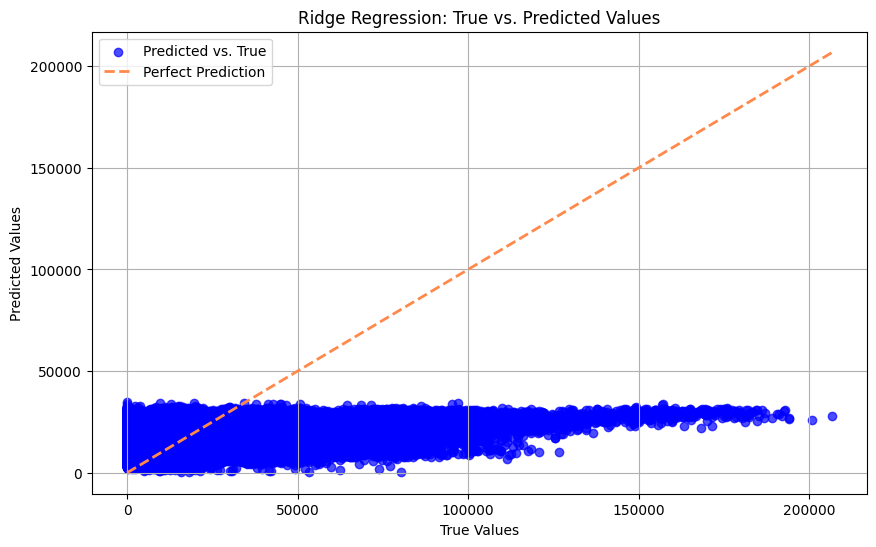

In [147]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_corrected, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Elastic Net Regression

#### Default model

In [67]:
## Baseline

elasticnet_default = ElasticNet(random_state = 42)

elasticnet_default.fit(X_dev, y_dev)

y_test_pred_default = elasticnet_default.predict(X_test)
y_test_pred_default = np.maximum(y_test_pred_default, 0) # can't have negative sales

test_mse_error_defaultenet = mean_squared_error(y_test, y_test_pred_default)
r2_score_defaultenet= r2_score(y_test, y_test_pred_default)
mae_defaultenet = mean_absolute_error(y_test, y_test_pred_default)

print(f"Default ElasticNet Test Mean Squared Error: {test_mse_error_defaultenet:.2f}")
print(f"Default ElasticNet Test R2 Score: {r2_score_defaultenet:.2f}")
print(f"Default ElasticNet Test Mean Absolute Error: {mae_defaultenet:.2f}")

Default ElasticNet Test Mean Squared Error: 443134596.40
Default ElasticNet Test R2 Score: 0.08
Default ElasticNet Test Mean Absolute Error: 14738.43


#### Hyperparameter Tuning

In [73]:
n_splits= 10
cv = KFold(n_splits)

# l1-l2 sscaling ratio
ratios = np.arange(0.1, 1, 0.01)
alphas = np.logspace(-4, 4, 100)

elastic_net_model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, random_state = 42)
elastic_net_model.fit(X_train, y_train)
en_train_score = elastic_net_model.score(X_train, y_train)
en_val_score = elastic_net_model.score(X_val, y_val)

print('Training score: '+str(en_train_score))
print('Validation score: '+str(en_val_score))

best_elasticnet_params = {
    'alpha': elastic_net_model.alpha_,
    'l1_ratio': elastic_net_model.l1_ratio_
    }
print('\nBest parameters: '+str(best_elasticnet_params))

Training score: 0.09384677189761059
Validation score: 0.055570659730560634

Best parameters: {'alpha': 4.037017258596558, 'l1_ratio': 0.9899999999999995}


In [75]:
best_elasticnet_model = ElasticNet(**best_elasticnet_params, random_state = 42) 
                  
best_elasticnet_model.fit(X_dev, y_dev)
y_test_pred_enet = best_elasticnet_model.predict(X_test)
y_test_pred_enet = np.maximum(y_test_pred_enet, 0)

test_mse_error_enet= mean_squared_error(y_test, y_test_pred_enet)
r2_score_enet = r2_score(y_test, y_test_pred_enet )
mae_enet = mean_absolute_error(y_test, y_test_pred_enet)
 
print(f"Hyperparamter-Tuned ElasticNet Test Mean Squared Error: {test_mse_error_enet:.2f}")
print(f"Hyperparamter-Tuned ElasticNet Test R2 Score: {r2_score_enet:.2f}")
print(f"Hyperparamter-Tuned ElasticNet Test Mean Absolute Error: {mae_enet:.2f}")

Hyperparamter-Tuned ElasticNet Test Mean Squared Error: 441689359.37
Hyperparamter-Tuned ElasticNet Test R2 Score: 0.09
Hyperparamter-Tuned ElasticNet Test Mean Absolute Error: 14728.45


#### Plot

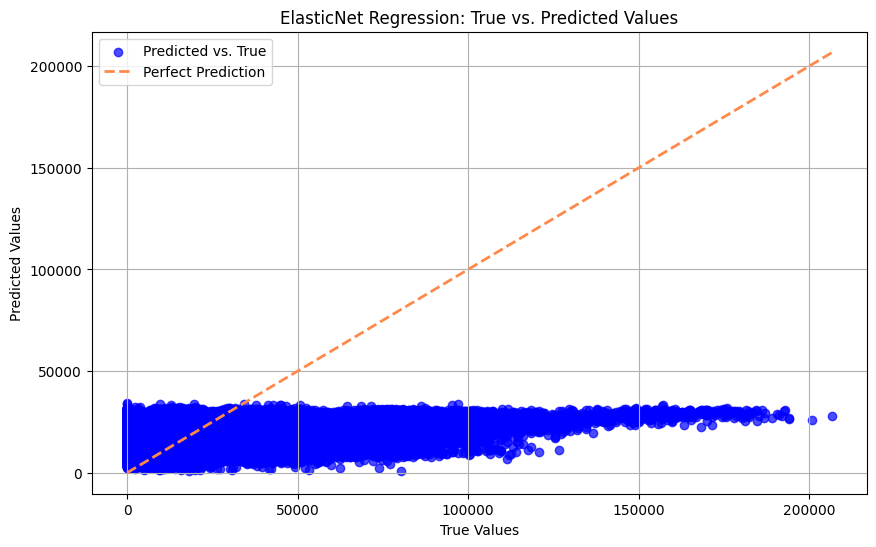

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_enet, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('ElasticNet Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Xgboost

In [71]:
xgb_model = XGBRegressor(random_state = 42, silent = True, verbosity = 0)

xgb_model.fit(X_dev, y_dev)

y_test_pred = xgb_model.predict(X_test)

test_mse_error_dxgb = mean_squared_error(y_test, y_test_pred)
r2_score_dxgb = r2_score(y_test, y_test_pred)
mae_dxgb = mean_absolute_error(y_test, y_test_pred)

print(f"Default XGBoost Test Mean Squared Error with Negative Predictions: {test_mse_error_dxgb:.2f}")
print(f"Default XGBoost Test R2 Score with Negative Predictions: {r2_score_dxgb:.2f}")
print(f"Default XGBoost Test Mean Absolute Error with Negative Predictions: {mae_dxgb:.2f}")

y_test_pred_corrected = np.maximum(y_test_pred, 0) # can't have negative sales

test_mse_error_dxgb_c= mean_squared_error(y_test, y_test_pred_corrected)
r2_score_dxgb_c = r2_score(y_test, y_test_pred_corrected )
mae_dxgb_c = mean_absolute_error(y_test, y_test_pred_corrected)
print("***")
print(f"Default XGBoost Test Mean Squared Error with Correction: {test_mse_error_dxgb_c:.2f}")
print(f"Default XGBoost Test R2 Score with Correction: {r2_score_dxgb_c:.2f}")
print(f"Default XGBoost Test Mean Absolute Error with Correction: {mae_dxgb_c:.2f}")
#print(f"Default Random Forest Regressor Test Mean Absolute Percentage Error: {mape_defaultrf:.2f}")

/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Default XGBoost Test Mean Squared Error with Negative Predictions: 54735070.75
Default XGBoost Test R2 Score with Negative Predictions: 0.89
Default XGBoost Test Mean Absolute Error with Negative Predictions: 4218.42
***
Default XGBoost Test Mean Squared Error with Correction: 53957773.71
Default XGBoost Test R2 Score with Correction: 0.89
Default XGBoost Test Mean Absolute Error with Correction: 4107.46


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

In [72]:
# Get the tree structure as text
tree_dump = xgb_model.get_booster().get_dump(with_stats=True)

# Print the tree structure and depth
for i, tree in enumerate(tree_dump):
    #print(f"Tree {i}:\n{tree}")
    tree_depth = tree.count('\n')  # Count the number of newline characters
    print(f"Tree {i} depth: {tree_depth}\n")

Tree 0 depth: 125

Tree 1 depth: 125

Tree 2 depth: 125

Tree 3 depth: 127

Tree 4 depth: 125

Tree 5 depth: 127

Tree 6 depth: 127

Tree 7 depth: 127

Tree 8 depth: 127

Tree 9 depth: 127

Tree 10 depth: 127

Tree 11 depth: 127

Tree 12 depth: 125

Tree 13 depth: 127

Tree 14 depth: 127

Tree 15 depth: 127

Tree 16 depth: 127

Tree 17 depth: 127

Tree 18 depth: 123

Tree 19 depth: 127

Tree 20 depth: 109

Tree 21 depth: 127

Tree 22 depth: 127

Tree 23 depth: 127

Tree 24 depth: 121

Tree 25 depth: 127

Tree 26 depth: 111

Tree 27 depth: 127

Tree 28 depth: 113

Tree 29 depth: 127

Tree 30 depth: 127

Tree 31 depth: 127

Tree 32 depth: 127

Tree 33 depth: 127

Tree 34 depth: 127

Tree 35 depth: 125

Tree 36 depth: 125

Tree 37 depth: 127

Tree 38 depth: 127

Tree 39 depth: 121

Tree 40 depth: 125

Tree 41 depth: 127

Tree 42 depth: 127

Tree 43 depth: 127

Tree 44 depth: 127

Tree 45 depth: 127

Tree 46 depth: 127

Tree 47 depth: 127

Tree 48 depth: 105

Tree 49 depth: 127

Tree 50 de

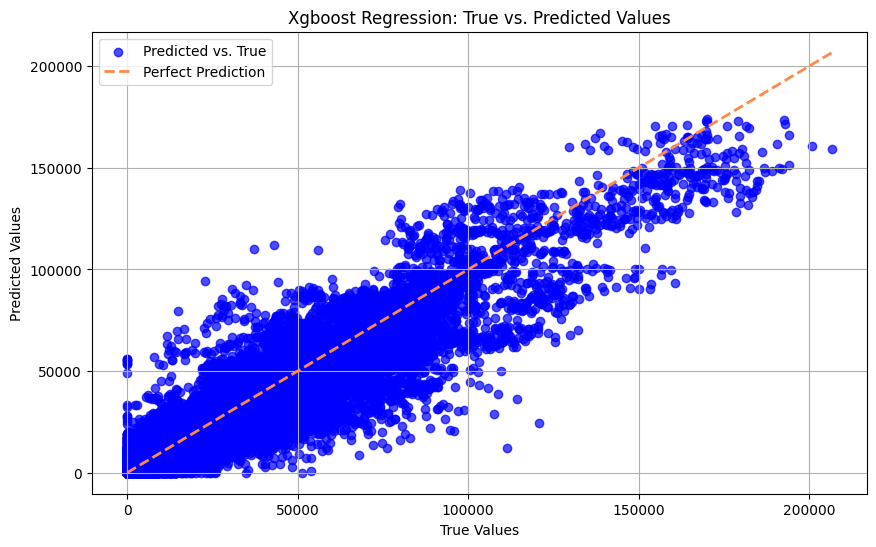

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_corrected, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Xgboost Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

In [74]:
#### Future Hypertuning - Takes long time to run
# a lot of warnings but this is the output: "Test Mean Squared Error: 50992727.47"
n_estimators_list = [100, 200, 300]
max_depth_list = [10, 50, 100, 130]
learning_rate_list = [0.01, 0.025, 0.1]
reg_alpha_list = np.logspace(-5, 2, num=5)



best_model = None
best_val_error = float('inf')

for n_estimators in n_estimators_list:
    print("Hyperparameter tuning with # of estimators: ", n_estimators)
    for max_depth in max_depth_list:
        print("Hyperparameter tuning with max_depth: ", max_depth)
        for learning_rate in learning_rate_list:
            print("Hyperparameter tuning with learning_rate: ", learning_rate)
            for reg_alpha in reg_alpha_list:
                print("Hyperparameter tuning with reg_alpha: ", reg_alpha)
                current_model = XGBRegressor(n_estimators=n_estimators, 
                                             max_depth=max_depth, 
                                             learning_rate=learning_rate, 
                                             reg_alpha=reg_alpha,
                                            random_state = 42
                                            )

                current_model.fit(X_train, y_train)

                y_val_pred = current_model.predict(X_val)

                val_error = mean_squared_error(y_val, y_val_pred)

                if val_error < best_val_error:
                    best_val_error = val_error
                    #best_model = current_model
                    best_params = {"n_estimators": n_estimators, 
                                  "max_depth":max_depth, 
                                   "learning_rate":learning_rate,
                                   "reg_alpha": reg_alpha
                                  }


best_model = XGBRegressor(**best_params, random_state = 42)                   
best_model.fit(X_dev, y_dev)

y_test_pred = best_model.predict(X_test)

test_mse_error_hxgb = mean_squared_error(y_test, y_test_pred)
r2_score_hxgb = r2_score(y_test, y_test_pred)
mae_hxgb = mean_absolute_error(y_test, y_test_pred)

print("Best Hyperparameter-Tuned XGBoost Model Parameters: ", list(best_params.items()))
print(f"Hyperparamter-Tuned XGBoost Test Mean Squared Error with Negative Predictions: {test_mse_error_hxgb:.2f}")
print(f"Hyperparamter-Tuned XGBoost Test R2 Score with Negative Predictions: {r2_score_hxgb:.2f}")
print(f"Hyperparamter-Tuned XGBoost Test Mean Absolute Error with Negative Predictions: {mae_hxgb:.2f}")

y_test_pred_corrected = np.maximum(y_test_pred, 0) # can't have negative sales

test_mse_error_hxgb_c= mean_squared_error(y_test, y_test_pred_corrected)
r2_score_hxgb_c = r2_score(y_test, y_test_pred_corrected )
mae_hxgb_c = mean_absolute_error(y_test, y_test_pred_corrected)

print("***")
print(f"Hyperparamter-Tuned XGBoost Test Mean Squared Error with Correction: {test_mse_error_hxgb_c:.2f}")
print(f"Hyperparamter-Tuned XGBoost Test R2 Score with Correction: {r2_score_hxgb_c:.2f}")
print(f"Hyperparamter-Tuned XGBoost Test Mean Absolute Error with Correction: {mae_hxgb_c:.2f}")


Hyperparameter tuning with # of estimators:  100
Hyperparameter tuning with max_depth:  10
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  50
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  100
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  130
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with # of estimators:  200
Hyperparameter tuning with max_depth:  10
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  50
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  100
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  130
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with # of estimators:  300
Hyperparameter tuning with max_depth:  10
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isi

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  50
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  100
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with max_depth:  130
Hyperparameter tuning with learning_rate:  0.01
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.025
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with learning_rate:  0.1
Hyperparameter tuning with reg_alpha:  1e-05


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.0005623413251903491


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  0.03162277660168379


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  1.7782794100389228


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Hyperparameter tuning with reg_alpha:  100.0


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Best Hyperparameter-Tuned XGBoost Model Parameters:  [('n_estimators', 300), ('max_depth', 10), ('learning_rate', 0.1), ('reg_alpha', 100.0)]
Hyperparamter-Tuned XGBoost Test Mean Squared Error with Negative Predictions: 50035221.32
Hyperparamter-Tuned XGBoost Test R2 Score with Negative Predictions: 0.90
Hyperparamter-Tuned XGBoost Test Mean Absolute Error with Negative Predictions: 3504.31
***
Hyperparamter-Tuned XGBoost Test Mean Squared Error with Correction: 49951982.33
Hyperparamter-Tuned XGBoost Test R2 Score with Correction: 0.90
Hyperparamter-Tuned XGBoost Test Mean Absolute Error with Correction: 3466.34


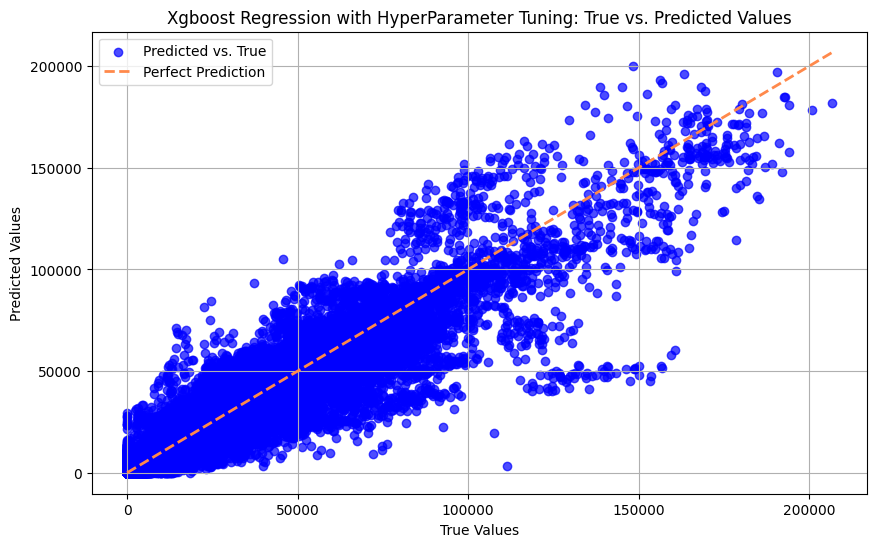

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_corrected, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Xgboost Regression with HyperParameter Tuning: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

#### Simple Forecasting

In [333]:
forescasting = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
forescasting['Date'] = pd.to_datetime(forescasting['Date'])
forescasting.set_index('Date', inplace=True)
forescasting.sort_index(inplace=True)

/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 6947909941600.174


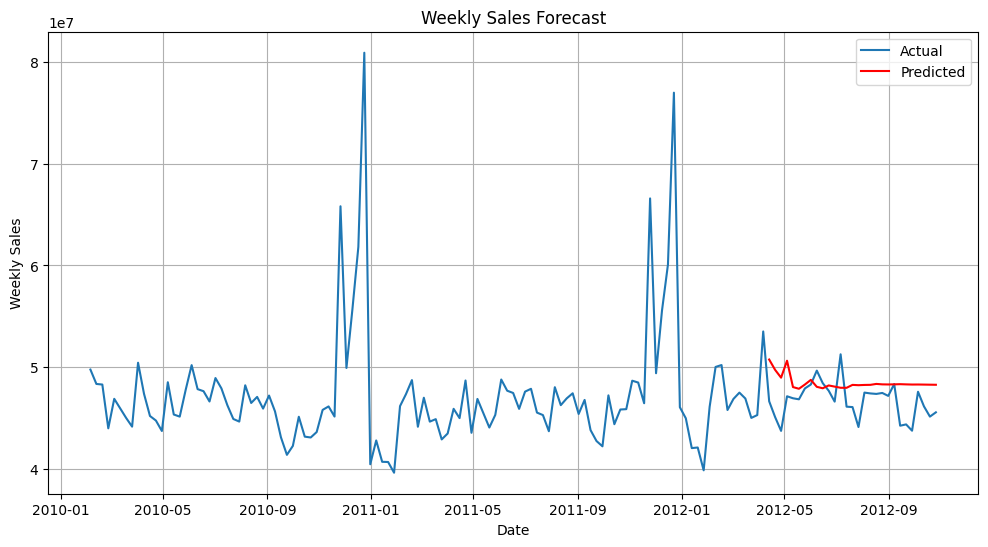

In [334]:
train_size = int(len(forescasting) * 0.8)
train_data = forescasting[:train_size]
test_data = forescasting[train_size:]

model = ARIMA(train_data['Weekly_Sales'], order=(10, 1, 1))
model_fit = model.fit()

predictions = model_fit.get_forecast(steps=len(test_data)).predicted_mean

mse = ((test_data['Weekly_Sales'] - predictions) ** 2).mean()
print(f"Mean Squared Error: {mse}")

plt.figure(figsize=(12, 6))
plt.plot(forescasting.index, forescasting['Weekly_Sales'], label='Actual')
plt.plot(test_data.index, predictions, color='red', label='Predicted')
plt.legend()
plt.title('Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

#### Additional Plot for showing forecasting importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


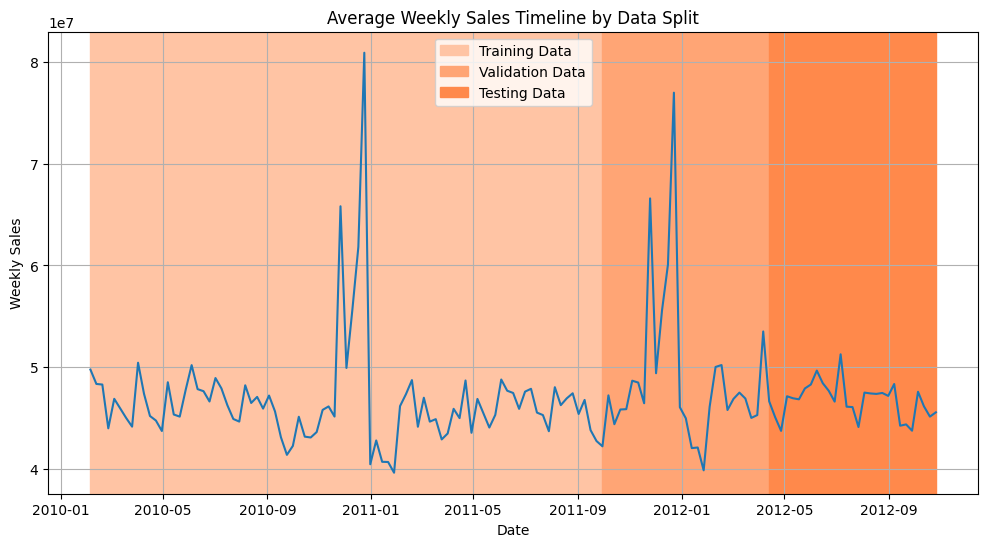

In [335]:
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)

train_data = df.iloc[train_size]['Date']
val_data = df.iloc[train_size+val_size]['Date']
test_data = df.iloc[-val_size]['Date']

plt.figure(figsize=(12, 6))
plt.plot(forescasting.index, forescasting['Weekly_Sales'])
plt.legend()
plt.title('Average Weekly Sales Timeline by Data Split')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

plt.grid(True)

plt.axvspan(df.iloc[0]['Date'], train_data, color='#ffc4a4', label='Training Data')
plt.axvspan(train_data, val_data, color='#ffa575', label='Validation Data')
plt.axvspan(val_data, df.iloc[-1]['Date'], color='#ff894b', label='Testing Data')

plt.legend()
plt.show()

## Random Forest Regressor

First test basic RandomForestRegressor without any hyperparameter tuning to get an idea of how it does with full purity

In [70]:

#default values since default depth will split until all leave nodes are pure
rf_default = RandomForestRegressor(random_state = 42,  oob_score = True)
rf_default.fit(X_dev, y_dev)

#y_val_pred = rf_default.predict(X_val)

y_test_pred = rf_default.predict(X_test)

#val_error = mean_squared_error(y_val, y_val_pred)
test_mse_error = mean_squared_error(y_test, y_test_pred)
r2_score_defaultrf = r2_score(y_test, y_test_pred)
mae_defaultrf = mean_absolute_error(y_test, y_test_pred)
#mape_defaultrf = mean_absolute_percentage_error(y_test, y_test_pred)

#print(f"Default Random Forest Regressor Val Mean Squared Error: {val_error:.2f}")
print(f"Default Random Forest Regressor Test Mean Squared Error with Negative Predictions:: {test_mse_error:.2f}")
print(f"Default Random Forest Regressor Test R2 Score with Negative Predictions:: {r2_score_defaultrf:.2f}")
print(f"Default Random Forest Regressor Test Mean Absolute Error with Negative Predictions:: {mae_defaultrf:.2f}")
#print(f"Default Random Forest Regressor Test Mean Absolute Percentage Error: {mape_defaultrf:.2f}")

y_test_pred_corrected = np.maximum(y_test_pred, 0) # can't have negative sales

test_mse_error_defaultrf_c= mean_squared_error(y_test, y_test_pred_corrected)
r2_score_defaultrf_c = r2_score(y_test, y_test_pred_corrected )
mae_defaultrf_c = mean_absolute_error(y_test, y_test_pred_corrected)

print("***")
print(f"Default Random Forest Regressor Test Mean Squared Error with Correction: {test_mse_error_defaultrf_c:.2f}")
print(f"Default Random Forest Regressor Test R2 Score with Correction: {r2_score_defaultrf_c:.2f}")
print(f"Default Random Forest Regressor Test Mean Absolute Error with Correction: {mae_defaultrf_c:.2f}")

Default Random Forest Regressor Test Mean Squared Error with Negative Predictions:: 28779362.47
Default Random Forest Regressor Test R2 Score with Negative Predictions:: 0.94
Default Random Forest Regressor Test Mean Absolute Error with Negative Predictions:: 2387.17
***
Default Random Forest Regressor Test Mean Squared Error with Correction: 28779362.47
Default Random Forest Regressor Test R2 Score with Correction: 0.94
Default Random Forest Regressor Test Mean Absolute Error with Correction: 2387.17


In [71]:
y_test_pred_low = y_test_pred[y_test_pred < 1]

In [72]:
y_test_pred_low #some predictions have very low sales, so do not use MAPE since it impacts the percentage

array([0.9617, 0.7321, 0.9564, 0.6899, 0.8101, 0.9755, 0.7794, 0.9428,
       0.8657, 0.6111])

In [73]:
x = [estimator.get_depth() for estimator in rf_default.estimators_[:20]]
print(x)

[41, 43, 43, 40, 43, 42, 41, 47, 41, 41, 41, 43, 45, 41, 40, 43, 44, 41, 40, 45]


#### Hyperparameter-Tuned Random Forest Regressor

Now let's try to improve our loss and R2 with hyperparameter tuning with the max_depth and n_estimators hyperparameters.

In [74]:
n_estimators = [50, 100, 150, 200, 250, 500]
max_depths = [20, 25, 30, 35, 40, 42]
# n_estimators = [50]
# max_depths = [20]

oob_scores = dict()
train_scores = []
test_scores = []
hyperparams = dict()

#cv done inherently by RF by nature of algorithm
i = 0
for estimators in n_estimators:
    print("Hyperparameter tuning with # of estimators: ", estimators)
    for depth in max_depths:
        
        rf_tuned = RandomForestRegressor(n_estimators = estimators,
                                          max_depth = depth,
                                          random_state = 42, oob_score = True)
        
        rf_tuned.fit(X_train, y_train)
        train_scores.append(rf_tuned .score(X_train, y_train))
        test_scores.append(rf_tuned .score(X_val, y_val))
        oob_scores[i] = rf_tuned.oob_score_ 
        hyperparams[i] = [estimators, depth] 
        
        i += 1
        

best_index = max(oob_scores, key = oob_scores.get)
best_n_estimators = hyperparams[best_index][0]
best_depth = hyperparams[best_index][1]

best_rf = RandomForestRegressor(n_estimators = best_n_estimators,
                                          max_depth = best_depth,
                                          random_state = 42, oob_score = True)

best_rf.fit(X_dev, y_dev)

y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

print(f"Best RF n_estimators:",  best_n_estimators)

print(f"Best RF max_depth:",  best_depth)

#val_error = mean_squared_error(y_val, y_val_pred)
test_mse_error = mean_squared_error(y_test, y_test_pred)
r2_score_hrf = r2_score(y_test, y_test_pred)
mae_hrf = mean_absolute_error(y_test, y_test_pred)
#mape_defaultrf = mean_absolute_percentage_error(y_test, y_test_pred)

#print(f"Default Random Forest Regressor Val Mean Squared Error: {val_error:.2f}")
print(f"Hyperparameter-Tuned Random Forest Regressor Test Mean Squared Error with Negative Predictions:: {test_mse_error:.2f}")
print(f"Hyperparameter-Tuned Random Forest Regressor Test R2 Score with Negative Predictions:: {r2_score_hrf:.2f}")
print(f"Hyperparameter-Tuned Random Forest Regressor Test Mean Absolute Error with Negative Predictions:: {mae_hrf:.2f}")
#print(f"Default Random Forest Regressor Test Mean Absolute Percentage Error: {mape_defaultrf:.2f}")

y_test_pred_corrected = np.maximum(y_test_pred, 0) # can't have negative sales

test_mse_error_hrf_c= mean_squared_error(y_test, y_test_pred_corrected)
r2_score_hrf_c = r2_score(y_test, y_test_pred_corrected )
mae_hrf_c = mean_absolute_error(y_test, y_test_pred_corrected)

print("***")
print(f"Hyperparameter-Tuned Random Forest Regressor Test Mean Squared Error with Correction: {test_mse_error_hrf_c:.2f}")
print(f"Hyperparameter-Tuned Random Forest Regressor Test R2 Score with Correction: {r2_score_hrf_c:.2f}")
print(f"Hyperparameter-Tuned Random Forest Regressor Test Mean Absolute Error with Correction: {mae_hrf_c:.2f}")

Hyperparameter tuning with # of estimators:  50
Hyperparameter tuning with # of estimators:  100
Hyperparameter tuning with # of estimators:  150
Hyperparameter tuning with # of estimators:  200
Hyperparameter tuning with # of estimators:  250
Hyperparameter tuning with # of estimators:  500
Best RF n_estimators: 500
Best RF max_depth: 30
Hyperparameter-Tuned Random Forest Regressor Test Mean Squared Error with Negative Predictions:: 27955440.47
Hyperparameter-Tuned Random Forest Regressor Test R2 Score with Negative Predictions:: 0.94
Hyperparameter-Tuned Random Forest Regressor Test Mean Absolute Error with Negative Predictions:: 2367.26
***
Hyperparameter-Tuned Random Forest Regressor Test Mean Squared Error with Correction: 27955440.47
Hyperparameter-Tuned Random Forest Regressor Test R2 Score with Correction: 0.94
Hyperparameter-Tuned Random Forest Regressor Test Mean Absolute Error with Correction: 2367.26


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is de

Text(0.5, 0, 'Feature Name')

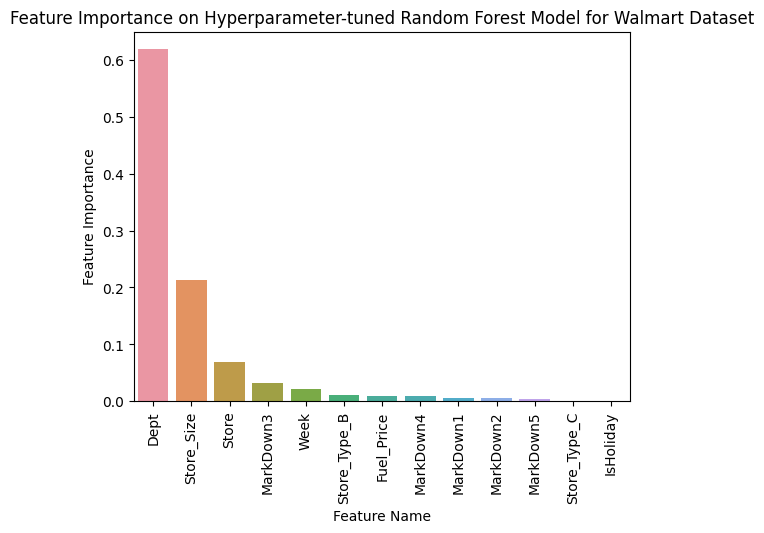

In [75]:
## YOUR CODE HERE
feature_names = X_train.columns.to_list()
feat_imps = zip(feature_names, best_rf.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] !=0, feat_imps)), key = lambda x: x[1], reverse = True)))
ax = sns.barplot(x = list(feats), y = list(imps))
ax.tick_params(axis = 'x', rotation = 90)
ax.set_title('Feature Importance on Hyperparameter-tuned Random Forest Model for Walmart Dataset')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Feature Name')

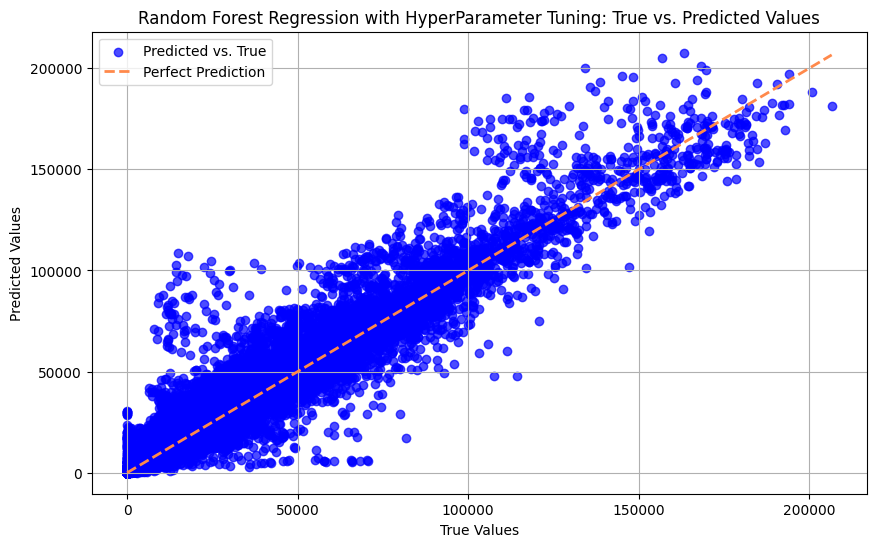

In [76]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_corrected, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression with HyperParameter Tuning: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Decision Trees Regression

#### Default model

In [ ]:
# Specifying the features to be used in this model
num_features = ['Store', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'Store_Size', 'Dept', 'IsHoliday', 'Week',
       'Store_Type_B', 'Store_Type_C']

tree_regressor = DecisionTreeRegressor(random_state= 42 ,max_depth=8)

tree_regressor.fit(df_X_dev[num_features], df_y_dev)

# Correcting for negative sales values
y_test_pred_corrected = np.maximum(tree_regressor.predict(df_X_test[num_features]),0)

print('Mean absolute error', mean_absolute_error(df_y_test, y_test_pred_corrected))
print('Mean Squared error', mean_squared_error(df_y_test, y_test_pred_corrected))
print('R2 score : ',r2_score(df_y_test, y_test_pred_corrected))

Mean absolute error 5863.69159720313
Mean Squared error 109387423.90681282
R2 score :  0.6842717594930838


#### Cross-Validated model

In [ ]:
# Cross validation to obtain the otimal values of max_depth and min_samples_split
best_tree = None
best_val_r2 = 0
best_depth = 0
best_min_split = 0

max_depths=[2, 3, 5, 7, 8 , 9 ,10, 15]
min_samples_splits = [2, 5, 7, 10, 20, 50]

for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        # Initialing a model with each paor of values max_depth and min_samples_split
        treeRegressor = DecisionTreeRegressor(max_depth = max_depth, min_samples_split = min_samples_split, random_state=42)
        treeRegressor.fit(df_X_train[num_features], df_y_train)
        val_r2 = r2_score(df_y_val, treeRegressor.predict(df_X_val[num_features]))

        # Updating the best parameters if we find a better R2 value
        if val_r2 > best_val_r2:
            best_tree = treeRegressor
            best_val_r2 = val_r2
            best_depth = max_depth
            best_min_split = min_samples_split

In [ ]:
# Obtaining the best estimator from the cross validaton & training it on the whole dev dataset
best_tree = DecisionTreeRegressor(max_depth = best_depth, min_samples_split = best_min_split, random_state=42)
best_tree.fit(df_X_dev[num_features], df_y_dev)

# Evaluating this optimal model on the test set
y_test_pred_corrected = np.maximum(best_tree.predict(df_X_test[num_features]),0)

print('Best tree: Mean absolute error', mean_absolute_error(df_y_test, y_test_pred_corrected))
print('Best tree: Mean Squared error', mean_squared_error(df_y_test, y_test_pred_corrected))
print('Best tree: R2 score : ',r2_score(df_y_test, y_test_pred_corrected))

Best tree: Mean absolute error 6453.798390059984
Best tree: Mean Squared error 109314960.5408421
Best tree: R2 score :  0.6844809127048701


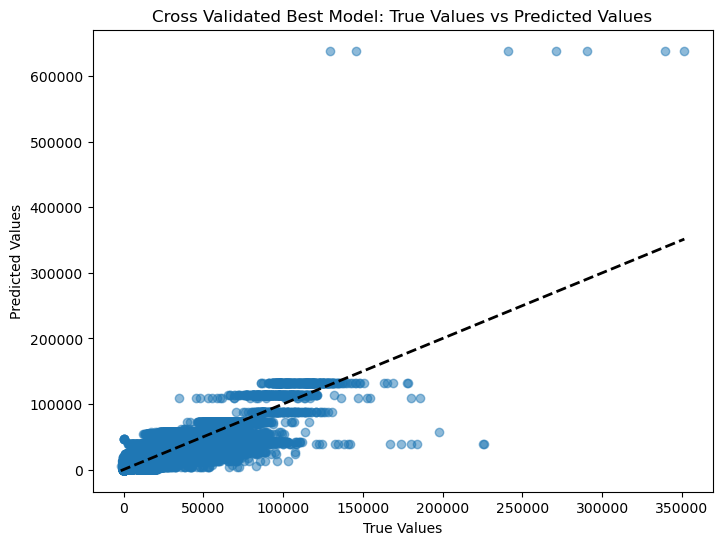

In [ ]:
# Plotting predicted vs actual values of sales along a perfect prediction line
plt.figure(figsize=(8, 6))

plt.scatter(df_y_test, best_tree.predict(df_X_test[num_features]) , alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Cross Validated Best Model: True Values vs Predicted Values')

# Diagonal line for perfect predictions
plt.plot([df_y_test.min(), df_y_test.max()], [df_y_test.min(), df_y_test.max()], 'k--', lw=2)
plt.show()

#### Pruning

In [ ]:
# Pruning the tree using Cost Complexity Pruning
alphasPath = best_tree.cost_complexity_pruning_path(df_X_test[num_features], df_y_test)

# Initializing the value of Alpha that corresponds to the best r2 score
best_alpha = 0
best_r2= 0

# List of alpha values to loop over
alphas=alphasPath.ccp_alphas

for alpha in alphas:
    prunedtree = DecisionTreeRegressor(max_depth = best_depth, min_samples_split = best_min_split, ccp_alpha = alpha, random_state=42)
    prunedtree.fit(df_X_train[num_features], df_y_train)
    # Replacing the best alpha value if its associated R2 score is the highest so far
    if (r2_score(df_y_val, prunedtree.predict(df_X_val[num_features])) > best_r2):
        best_alpha = alpha
        best_r2 = r2_score(df_y_val, prunedtree.predict(df_X_val[num_features]))

# Displaying the optimal value of alpha and its associated R2 score
print("Best alpha is:", best_alpha)
print("Best r2 is:", best_r2)

Best alpha is: 305768.15987207514
Best r2 is: 0.5438301375089636


In [ ]:
# Training a decision tree using the best alpha value
optimalPrunedTree = DecisionTreeRegressor(max_depth = best_depth, min_samples_split = best_min_split,  ccp_alpha = best_alpha, random_state=42)
optimalPrunedTree.fit(df_X_dev[num_features], df_y_dev)

# Evaluating the pruned decision tree
y_test_pred_corrected = np.maximum(optimalPrunedTree.predict(df_X_test[num_features]),0)

print("Pruned tree's r2 score is:", r2_score(df_y_test, y_test_pred_corrected))
print('Pruned tree: mean absolute error', mean_absolute_error(df_y_test, y_test_pred_corrected))
print('Pruned tree: mean squared error', mean_squared_error(df_y_test, y_test_pred_corrected))

Pruned tree's r2 score is: 0.6576441994615783
Pruned tree: mean absolute error 7085.899562955033
Pruned tree: mean squared error 118612826.7155508


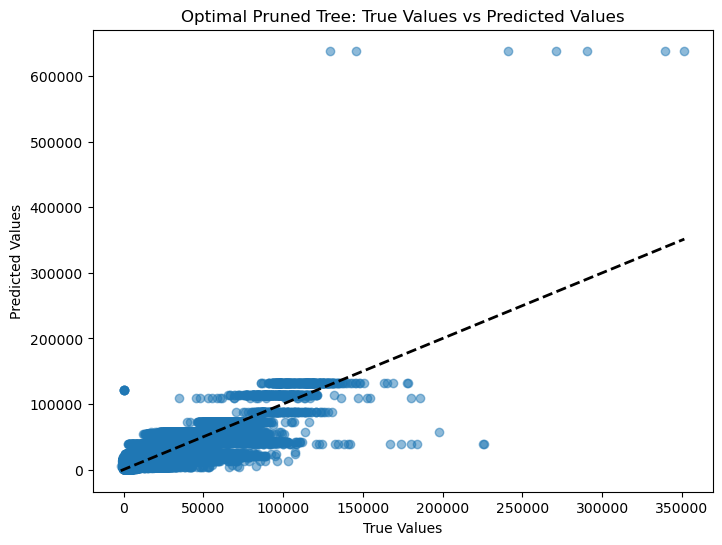

In [ ]:
# Plotting actual vs predicted values obtained through the optimal pruned regression tree
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(df_y_test, optimalPrunedTree.predict(df_X_test[num_features]) , alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Optimal Pruned Tree: True Values vs Predicted Values')

# diagonal line for perfect predictions
plt.plot([df_y_test.min(), df_y_test.max()], [df_y_test.min(), df_y_test.max()], 'k--', lw=2)
plt.show()

#### Linear Regression Trees

<b>Reference:</b><br> "Linear Trees differ from Decision Trees because they compute linear approximation (instead of constant ones) fitting simple Linear Models in the leaves." <br>- https://datascience.stackexchange.com/questions/65585/decision-tree-with-final-decision-being-a-linear-regression

In [ ]:
! pip install --upgrade linear-tree

In [ ]:
from lineartree import LinearTreeRegressor

# Initialing the linear tree regressor
regr = LinearTreeRegressor(base_estimator=LinearRegression())
regr.fit(df_X_dev[num_features], df_y_dev)

LinearTreeRegressor(base_estimator=LinearRegression())

In [ ]:
# Evaluating the default linear tree regressor model
y_test_pred_corrected = np.maximum(regr.predict(df_X_test[num_features]),0)

print('Linear Tree Regressor: mean absolute error', mean_absolute_error(df_y_test, y_test_pred_corrected))
print('Linear Tree Regressor: r2 score : ',r2_score(df_y_test, y_test_pred_corrected))

Linear Tree Regressor: mean absolute error 7647.743488713705
Linear Tree Regressor: r2 score :  0.5205695832997232


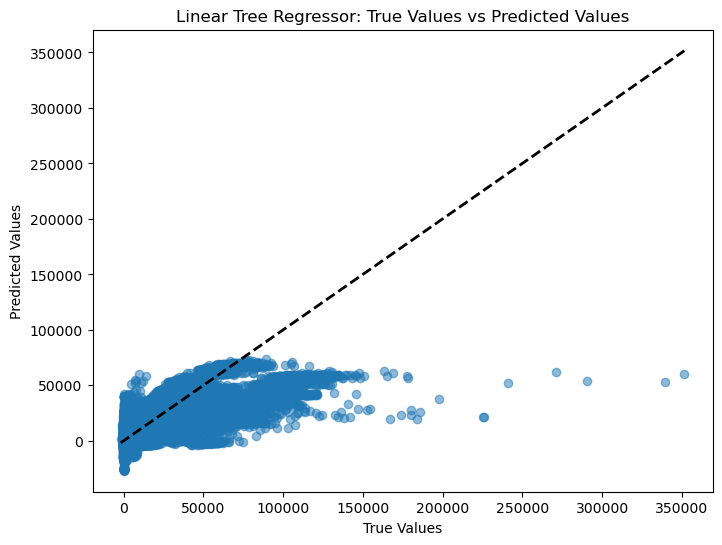

In [ ]:
# Plotting actual values vs predicted values by the linear tree regressor
plt.figure(figsize=(8, 6))

plt.scatter(df_y_test, regr.predict(df_X_test[num_features]) , alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Linear Tree Regressor: True Values vs Predicted Values')

# diagonal line for perfect predictions
plt.plot([df_y_test.min(), df_y_test.max()], [df_y_test.min(), df_y_test.max()], 'k--', lw=2)
plt.show()

In [67]:
!pip install lightgbm